# Pickup and Delivery Orienteering Problem with Time Window (PDOTW)
## For generating initial solutions of PDPT
### Simplest idea with best results (for the 5 datasets provided by Fujitsu) so far
- Please try adding LNS that considers transfers after obtaining the initial solutions to improve solution quality. The LNS can be simply adapted from the LNS implementation in the cluster-route-schedule approach.

In [1]:
# Import all libraries
import sys, os, datetime, math
import numpy as np
import string   
import random
import time
# docplex is for CP Optimizer
from docplex.cp.model import *
# gurobipy is for Gurobi Optimizer
from gurobipy import *
import csv
import networkx as nx
import matplotlib.pyplot as plt
from pandas import *

# Read .csv files

In [2]:
def read_constant():
    """
    Read the Constant.csv
    return a dictionary: constant
    e.g., 
    constant['truck_fixed_cost'] = 30000
    constant['truck_running_cost'] = 50
    constant['cargo_reloading_cost'] = 0.5
    constant['node_fixed_time'] = 11
    constant['loading_variation_coefficient'] = 0.00946
    """
    constant = {}
    csv_reader = csv.reader(open("./Constant.csv"))
    for line in csv_reader:
        if line[1] != 'value':
            constant[line[0]] = float(line[1])
    
    return constant

In [3]:
def read_cargo_model():
    """
    Read the Cargo_model.csv
    return a dict<list>: cargo
    e.g., 
    cargo['nb_cargo'] = ['size', 'lb_time', 'ub_time',
                         'departure_node', 'arrival_node']
    cargo['c1'] = [915, 125, 762, 'N7', 'N22']
    """
    cargo = {}
    csv_reader = csv.reader(open("./Cargo_model.csv"))
    for line in csv_reader:
        if line[0] != 'nb_cargo':
            cargo[line[0]] = (int(line[1]), int(line[2]), 
                              int(line[3]), line[4], line[5])
            
    return cargo

In [4]:
def read_daiya_model():
    """
    Read the Daiya_model.csv
    The file stores all information of trucks
    return a dict<list>: truck
    e.g.,
    truck['nb_truck'] = ['departure_node', 'arrival_node', 
                         'max_worktime', 'max_capacity']
    truck[T1] = ['N7', 'N30', 780, 10000]
    """
    truck = {}
    csv_reader = csv.reader(open("./Daiya_model.csv"))
    for line in csv_reader:
        if line[0] != 'nb_truck':
            truck[line[0]] = (line[1], line[2], int(line[3]), int(line[4]))
            
    return truck

In [5]:
def read_edge_list():
    """
    Read the Edge_list.csv
    return a dict<int>: edge
    Symmetrical
    e.g., 
    edge[('start_node', 'end_node')] = runtime
    edge[('N1', 'N2')] = 70
    edge[('N2', 'N1')] = 70
    Also, return a list of nodes:
        node = ['N1', 'N2', ...]
    """
    edge = {}
    node_list = []
    csv_reader = csv.reader(open("./Edge_list.csv"))
    for line in csv_reader:
        if line[0] != 'start_node':
            if line[0] not in node_list:
                node_list.append(line[0])
            if line[1] not in node_list:
                node_list.append(line[1])
            edge[(line[0], line[1])] = int(line[2])
            # create 0 distance edge
            edge[(line[0], line[0])] = 0
    
    print('\nThe nodes are:')
    print(node_list)
#     assert int(edge[('N13', 'N19')])==0, "wrong edge length!"
    
    return node_list, edge

In [6]:
def read_case():
    """
    Read all(4) files in a Case
    return a tuple (constant, cargo, truck, node_list, edge)
    """
    
    constant = read_constant()
    cargo = read_cargo_model()
    truck = read_daiya_model()
    node_list, edge = read_edge_list()
    
    return (constant, cargo, truck, node_list, edge)

# Read coodinates_nx and coordinates_FastMap

In [7]:
def read_coordinates_nx(node_list):
    """
    Read coordinates obtained from networkX
    Output:
        coordinates[N1] = (x, y)
    """
    
    # generate the file name
    filename = 'coordinates_nx.txt'
    f = open(filename, 'r')
    
    coordinates = {}
    for i in range(len(node_list)):
        param = f.readline()
        list_param = param.split()
        coordinates[list_param[0]] = \
        (float(list_param[1]), float(list_param[2]))
        
    assert len(coordinates) == len(node_list)
    
    f.close()
    
    print('\nThe coordinates obtained from networkX:')
    for key, value in coordinates.items():
        print(key, value[0], value[1])
    
    return coordinates

In [8]:
def read_coordinates_FastMap(node_list):
    """
    Read coordinates obtained from FastMap
    Output:
        coordinates[N1] = (x, y)
    """
    
    # generate the file name
    filename = 'coordinates_FastMap.txt'
    f = open(filename, 'r')
    
    coordinates = {}
    for i in range(len(node_list)):
        param = f.readline()
        list_param = param.split()
        coordinates[list_param[0]] = \
        (float(list_param[1]), float(list_param[2]))
        
    assert len(coordinates) == len(node_list)
    
    f.close()
    
    print('\nThe coordinates obtained from FastMap:')
    for key, value in coordinates.items():
        print(key, value[0], value[1])
    
    return coordinates

- Call networkX to draw maps

In [9]:
def networkx_generate_graph(nb_nodes, node_list, edge, community, hub):
    """
    Use networkx to generate a graph
    based on the incomplete distance matrix
    return the coordinates of the graph

    The graphs are not very accurate
    Use FastMap instead

    Inputs:
        nb_nodes = int
        node_list = [N1, N2, ...]
        community[N1] = 1
        hub[1] = N1
    Outputs:
        node_coordinates[N1] = (x, y)
    """
    
    import networkx as nx
    import graphviz
    import pydot
    
    dt = [('len', float)]       
    
    distance_matrix = []
    for i in range(nb_nodes):
        distance_matrix.append([])
        node_i = node_list[i]
        for j in range(nb_nodes):
            node_j = node_list[j]
            if node_i == node_j:
                distance_matrix[i].append(0)
            else:
                if (node_i,node_j) in edge.keys() and \
                   (node_j,node_i) in edge.keys():
                    length = (edge[(node_i,node_j)] + \
                              edge[(node_j,node_i)]) / 2
                    distance_matrix[i].append(length)
                elif (node_i,node_j) in edge.keys():
                    distance_matrix[i].append(edge[(node_i,node_j)])   
                elif (node_j,node_i) in edge.keys():
                    distance_matrix[i].append(edge[(node_j,node_i)])
                else:
                    distance_matrix[i].append(avg_length)  
            if int(distance_matrix[i][j]) < 1:
                distance_matrix[i][j] = 1
#     assert int(distance_matrix[12][18])==1, "wrong distance matrix!"
    
    A = np.array(distance_matrix)
    
    A = A.view(dt)

    G = nx.from_numpy_matrix(A)
    mapping = {}
    for i in range(nb_nodes):
        mapping[i] = 'N'+str(i+1)

    color = ['red', 'cyan', 'lawngreen', 'lightskyblue', 
            'pink', 'darkgreen', 'navy', 'peru', 
            'deepskyblue', 'orange', 'slategrey', 'gold',
            'blue', 'blueviolet', 'palegreen', 'violet', 
            'rosybrown', 'silver', 'crimson', 
            'deepskyblue']
    
    sizes = []
    node_color = []
    for node in node_list:
        node_color.append(color[community[node]])
        if hub[community[node]] == node:
            sizes.append(1500)
        else:
            sizes.append(500)

    import matplotlib.pyplot as plt

    plt.figure(figsize=(15,15))
    
    
    # The graphviz_layout should be the best!
    nx.draw_networkx_nodes(G, pos=nx.nx_pydot.graphviz_layout(G), 
                           node_size=sizes, node_color=node_color)
    
    nx.relabel_nodes(G, mapping, copy=False)
    print(list(G.nodes))
    
    
    node_coordinates = nx.nx_pydot.graphviz_layout(G)
    print("\nnode_coordinates :")
    for key, value in node_coordinates.items():
        print(key, value[0], value[1])
    
    nx.draw_networkx_labels(G, pos=nx.nx_pydot.graphviz_layout(G), 
                            font_size=10, font_color='black',)
    
    plt.savefig("map_nx.pdf")

    return node_coordinates

# Preprocessing

- Generate node_cargo_size_change

In [10]:
def generate_node_cargo_size_change(node_list, cargo):
    """
    Generate node_cargo_size_change,
    which is very useful in the PDPTW or PDOTW model.

    Inputs:
        node_list = [N1, N2, ...]
        cargo[c] = (size, lb, ub, origin, destination)
    Outputs:
        node_cargo_size_change[(n, c)] =  0 if n is not oc / dc
        node_cargo_size_change[(n, c)] =  cargo_size if n is oc 
        node_cargo_size_change[(n, c)] = -cargo_size if n is dc
    """
    
    node_cargo_size_change = {}
    for n in node_list:
        for c in cargo.keys():
            if n == cargo[c][3]:
                node_cargo_size_change[(n, c)] = cargo[c][0]
            elif n == cargo[c][4]:
                node_cargo_size_change[(n, c)] = -cargo[c][0]
            else:
                node_cargo_size_change[(n, c)] = 0
    
    return node_cargo_size_change

- Select cargos and trucks for MIP model debugging

In [11]:
def select_cargo_truck(cargo, truck, length_cargo, length_truck, 
                       node_list, edge):
    """
    This function is for debugging the code and checking the solution.
    Do not need to use it often.

    select cargo and truck such that 
    the length of selected_cargo is length_cargo
    the length of created_truck is length_truck
    Outputs:
        selected_cargo
        created_truck
        selected_node
        selected_edge
    """
    
    ### TODO: add randomness
    
    selected_cargo = {}
    created_truck = {}
    selected_node = []
    selected_edge = {}
    
    # randomly shuffle all cargo and select the first few
    cargo_list = list(cargo.keys())
    random.shuffle(cargo_list)
    # randomly shuffle all trucks and select the first few
    truck_list = list(truck.keys())
    random.shuffle(truck_list)
    
    for i in range(length_cargo):
        key = cargo_list[i]
        value = cargo[key]
        selected_cargo[key] = value
        if value[3] not in selected_node:
            selected_node.append(value[3])
        if value[4] not in selected_node:
            selected_node.append(value[4])
    
    for i in range(length_truck):
        key = truck_list[i]
        value = truck[key]
        created_truck[key] = value
        if value[0] not in selected_node:
            selected_node.append(value[0])
        if value[1] not in selected_node:
            selected_node.append(value[1])
    
    # only select nodes that are truck/cargo origins/destinations
    for node1 in selected_node:
        for node2 in selected_node:
            selected_edge[(node1, node2)] = edge[(node1, node2)]
    
    assert len(selected_cargo) == length_cargo, \
    "length of selected_cargo is incorrect!"
    assert len(created_truck) == length_truck, \
    "length of created_truck is incorrect!"
    print('\nThe length of selected_node is:', len(selected_node))
    print('The selected_node:', selected_node)
    print('\nThe selected_cargo:')
    for key, value in selected_cargo.items():
        print(key, value, selected_edge[(value[3], value[4])])
    print('\nThe created_truck:')
    for key, value in created_truck.items():
        print(key, value, selected_edge[(value[0], value[1])])
    
    return selected_cargo, created_truck, selected_node, selected_edge

- Create cycle trucks

In [12]:
def create_cycle_truck(created_truck, ratio):
    """
    This function is for debugging the code and checking the solution.
    Do not need to use it often.

    make the origin and destination of some truck
    being the same
    from the created_truck
    Inputs:
        created_truck[T1] = (origin, destination, size, worktime)
        ratio is in (0,1): ratio of cycle trucks
    Outputs:
        created_truck_yCycle: same origin and destination
        created_truck_nCycle: different origin and destination
        created_truck_all = created_truck_yCycle + created_truck_nCycle
    """
    
    created_truck_yCycle = {}
    created_truck_nCycle = {}
    created_truck_all = {}
    
    # Use the ratio to control the probability of cycle trucks
    for key, value in created_truck.items():
        flag = random.random()
        if flag <= ratio:
            # modify the truck to be a cycle truck
            created_truck_yCycle[key] = \
            (value[0], value[0], value[2], value[3])
        else:
            # keep the truck to be a non-cycle truck
            created_truck_nCycle[key] = \
            (value[0], value[1], value[2], value[3])
    
    print('\nThe cycle trucks:')
    for key, value in created_truck_yCycle.items():
        created_truck_all[key] = value
        print(key, value)
    print('\nThe non-cycle trucks:')
    for key, value in created_truck_nCycle.items():
        created_truck_all[key] = value
        print(key, value)
    print('\nAll selected trucks:')
    for key, value in created_truck_all.items():
        print(key, value)
    
    
    return created_truck_yCycle, created_truck_nCycle, created_truck_all

- Group cycle trucks

In [13]:
def group_cycle_truck(created_truck):
    """
    Group trucks whose origin and destination are the same
    from the created_truck
    Inputs:
        created_truck[T1] = (origin, destination, size, worktime)
    Outputs:
        created_truck_yCycle: same origin and destination
        created_truck_nCycle: different origin and destination
        created_truck_all = created_truck_yCycle + created_truck_nCycle
    """
    
    created_truck_yCycle = {}
    created_truck_nCycle = {}
    created_truck_all = {}
    
    for key, value in created_truck.items():
        flag = random.random()
        if value[0] == value[1]:
            # modify the truck to be a cycle truck
            created_truck_yCycle[key] = \
            (value[0], value[0], value[2], value[3])
        else:
            # keep the truck to be a non-cycle truck
            created_truck_nCycle[key] = \
            (value[0], value[1], value[2], value[3])
    
#     print('\nThe cycle trucks:')
    for key, value in created_truck_yCycle.items():
        created_truck_all[key] = value
#         print(key, value)
#     print('\nThe non-cycle trucks:')
    for key, value in created_truck_nCycle.items():
        created_truck_all[key] = value
#         print(key, value)
#     print('\nAll selected trucks:')
#     for key, value in created_truck_all.items():
#         print(key, value)
    
    
    return created_truck_yCycle, created_truck_nCycle, created_truck_all

- plot gurobi solution with FastMap

In [14]:
def plot_gurobi_solution_FastMap(selected_cargo, 
    created_truck_yCycle, created_truck_nCycle, created_truck_all, 
    selected_edge, selected_node, 
    x_sol, z_sol, y_sol, S_sol, D_sol, A_sol, Sb_sol, Db_sol, Ab_sol, 
    coordinates_FastMap):
    
    """
    Plot the gurobi MIP solution
    Plot truck routes seperately
    Outputs:
        truck_used = []
        truck_route[truck_] = [N1, N2, ...]
    """
    
    
    ###### Preprocess the gurobi solution ######
    
    truck_used = []
    truck_unused = []
    truck_route = {}

    # classify used/unused trucks
    for truck_ in created_truck_all.keys():
        if z_sol[truck_] == 1:
            truck_used.append(truck_)
            truck_route[truck_] = []
        else:
            truck_unused.append(truck_)
#     print('\nThe truck_used:', truck_used)
    
    # only look for routes for used trucks
    for truck_ in truck_used:
        source = created_truck_all[truck_][0]
        truck_route[truck_].append(source)
        # do not need to specify created_truck_yCycle
        # with the following while loop structure
        for node_ in selected_node:
            if node_ != source and x_sol[(source, node_, truck_)] == 1:
                truck_route[truck_].append(node_)
                source = node_
                break
        while source != created_truck_all[truck_][1]:
            for node_ in selected_node:
                if node_ != source and x_sol[(source, node_, truck_)] == 1:
                    truck_route[truck_].append(node_)
                    source = node_
                    break

                
    # take a look at all truck routes
    print('\nThe truck_route:')
    for key, value in truck_route.items():
        print(key, value)
        
        
    
    import matplotlib.pyplot as plt

    
    
    ###### Plot truck routes ######
    
    # map node to node_index
    node_index = {}
    count = 0
    for node_ in selected_node:
        # print(node)
        node_index[node_] = count
        count += 1
    
    # map truck to truck_index
    truck_index = {}
    count = 0
    for truck_ in created_truck_all.keys():
        # print(truck)
        truck_index[truck_] = count
        count += 1
        
    # each truck has a different color
    # use 15 colors for now
    # shuffle the truck_color
    truck_color = np.array(['red', 'cyan', 'lawngreen', 'lightskyblue', 
                            'pink', 'darkgreen', 'navy', 'peru', 
                            'deepskyblue', 'orange', 'slategrey', 'gold',
                            'blue', 'blueviolet', 'palegreen', 'violet', 
                            'rosybrown', 'silver', 'crimson', 
                            'deepskyblue', 'black'])
    # np.random.shuffle(truck_color)
    # print("The list of colors for trucks is:", truck_color)
    
    # initialize truck routes dictionary   
    truck_names = []
    sizes = []
    colors = []
    # truck_x and truck_y are lists of x/y-coordinates
    # Can be tuned to better display routes
    truck_x = []
    truck_y = []
    for truck_ in truck_used:
        print('The truck', truck_, 'is used!')
        print(created_truck_all[truck_])
        truck_names.append(truck_)
        truck_x.append(25)
        truck_y.append(20 - truck_index[truck_] * 0)
        colors.append(truck_color[truck_index[truck_]])
        sizes.append(100)
#     ax_truck.scatter(truck_x, truck_y, s=sizes, c=colors)
    
    print('\nThe number of used trucks is:', len(truck_used))
    
    
    ###### For each truck, plot the route ###### 
    
    for i, txt in enumerate(truck_names):
        
        truck_ = txt
        
        ###### Plot nodes ######
        
        # node coordinates
        x_node = []
        y_node = []  
        for node_ in selected_node:
            x_node.append(coordinates_FastMap[node_][0])
            y_node.append(coordinates_FastMap[node_][1])

        # scatter plot of nodes
        sizes = [300+i*0 for i in range(len(selected_node))]
        fig_truck, ax_truck = plt.subplots(figsize=(15,15))
        ax_truck.title.set_text('Truck Routes')
        ax_truck.scatter(x_node, y_node, s=sizes, c='silver')
        ax_truck.annotate(truck_, (truck_x[i], truck_y[i]))
        
        for i, txt in enumerate(selected_node):
            ax_truck.annotate(txt, (x_node[i], y_node[i]))
            
        
        # for each node along a truck route
        # plot its current size, arrival time, and departure time
        # by using S_sol, A_sol, and D_sol
        # or Sb_sol, Ab_sol, and Db_sol for the destinations of cycle trucks
        for node_ in selected_node:
            if truck_ in created_truck_yCycle.keys() and \
               node_ == created_truck_yCycle[truck_][1]:
                size_node = S_sol[(node_, truck_)]
                arrival_node = A_sol[(node_, truck_)]
                departure_node = str(D_sol[(node_, truck_)]) + '   START'
                SAD = 'S:' + str(size_node) + \
                      ' A:' + str(arrival_node) + \
                      ' D:' + str(departure_node)
                ax_truck.annotate(SAD, (coordinates_FastMap[node_][0]+10, 
                                        coordinates_FastMap[node_][1]+3))
                size_node = Sb_sol[(node_, truck_)]
                arrival_node = Ab_sol[(node_, truck_)]
                departure_node = str(Db_sol[(node_, truck_)]) + '   END'
                SAD = 'S:' + str(size_node) + \
                      ' A:' + str(arrival_node) + \
                      ' D:' + str(departure_node)
                ax_truck.annotate(SAD, (coordinates_FastMap[node_][0]+10, 
                                        coordinates_FastMap[node_][1]-3))
                cargo_load_node = []
                cargo_unload_node = []
                for cargo_ in selected_cargo.keys():
                    if y_sol[(truck_, cargo_)] == 1:
                        if selected_cargo[cargo_][3] == node_:
                            cargo_load_node.append(cargo_)
                        if selected_cargo[cargo_][4] == node_:
                            cargo_unload_node.append(cargo_)
                cargo_node_str = ''
                if len(cargo_load_node) > 0:
                    for cargo_ in cargo_load_node:
                        cargo_node_str += str(cargo_)
                        cargo_node_str += ':+'
                        cargo_node_str += str(selected_cargo[cargo_][0])
                        cargo_node_str += ' '
                ax_truck.annotate(cargo_node_str, 
                                  (coordinates_FastMap[node_][0]+10, 
                                   coordinates_FastMap[node_][1]-0.0))
                cargo_node_str = ''
                if len(cargo_unload_node) > 0:
                    for cargo_ in cargo_unload_node:
                        cargo_node_str += str(cargo_)
                        cargo_node_str += ':-'
                        cargo_node_str += str(selected_cargo[cargo_][0])
                        cargo_node_str += ' '
                ax_truck.annotate(cargo_node_str, 
                                  (coordinates_FastMap[node_][0]+10, 
                                   coordinates_FastMap[node_][1]-6))
            else:
                size_node = S_sol[(node_, truck_)]
                arrival_node = A_sol[(node_, truck_)]
                departure_node = D_sol[(node_, truck_)]
                SAD = 'S:' + str(size_node) + \
                      ' A:' + str(arrival_node) + \
                      ' D:' + str(departure_node)
                ax_truck.annotate(SAD, (coordinates_FastMap[node_][0]+10, 
                                        coordinates_FastMap[node_][1]))
                cargo_load_node = []
                cargo_unload_node = []
                for cargo_ in selected_cargo.keys():
                    if y_sol[(truck_, cargo_)] == 1:
                        if selected_cargo[cargo_][3] == node_:
                            cargo_load_node.append(cargo_)
                        if selected_cargo[cargo_][4] == node_:
                            cargo_unload_node.append(cargo_)
                cargo_node_str = ''
                if len(cargo_load_node) > 0:
                    for cargo_ in cargo_load_node:
                        cargo_node_str += str(cargo_)
                        cargo_node_str += ':+'
                        cargo_node_str += str(selected_cargo[cargo_][0])
                        cargo_node_str += ' '
                if len(cargo_unload_node) > 0:
                    for cargo_ in cargo_unload_node:
                        cargo_node_str += str(cargo_)
                        cargo_node_str += ':-'
                        cargo_node_str += str(selected_cargo[cargo_][0])
                        cargo_node_str += ' '
                ax_truck.annotate(cargo_node_str, 
                                  (coordinates_FastMap[node_][0]+10, 
                                   coordinates_FastMap[node_][1]-3))
            
        # plot truck routes from truck_route
        for i in range(len(truck_route[truck_])-1):
            node1 = truck_route[truck_][i]
            node2 = truck_route[truck_][i+1]
            x = np.array([ x_node[node_index[node1]],
                           x_node[node_index[node2]] ])
            y = np.array([ y_node[node_index[node1]] 
                           + truck_index[truck_] * 0.0,
                           y_node[node_index[node2]]
                           + truck_index[truck_] * 0.0    ])
            # ax_truck.plot(x,y,color=truck_color[truck_index[truck]])
            ax_truck.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1],
                            scale_units='xy', angles='xy', scale=1,
                            color=truck_color[truck_index[truck_]], 
                            width = 0.004)
                    
                    
        ###### Show the plot ######

        plt.savefig("truck_route_{}.pdf".format(truck_))
        plt.show()
    
    
    return truck_used, truck_unused, truck_route

- calculate minimum time needed for cargo

In [15]:
def calculate_min_cargo_time(cargo, edge):
    """
    Calculate the minimum time for delivering a cargo,
    i.e., directly from the cargo origin to the cargo destination.
    Inputs:
        cargo[C1] = (size, lb, ub, origin, destination)
        edge[(N1, N2)] = length
    Outputs:
        min_cargo_time[C1] = min_time
    """
    
    min_cargo_time = {}
    
    print('\nThe min_cargo_time:')
    for key, value in cargo.items():
        min_cargo_time[key] = edge[(value[3], value[4])]
        print(key, min_cargo_time[key])
    
    
    return min_cargo_time

- Calculating all pairs shortest path length using networkX

In [16]:
def replace_edge_by_shortest_length_nx(node_list, edge):
    
    """
    This function is IMPORTANT!
    
    Since the triangle inequality may be violated,
    we replace the edge length of all pair nodes by
    the shortest path length between them
    by using networkX in a directed graph
    Function used in nx: all_pairs_dijkstra_path_length
    
    Inputs:
        node_list
        edge
    Outputs:
        edge_shortest[(N1, N2)] = shortest path length between N1 and N2
        path_shortest[(N1, N2)] = [N1, N3, N5, N2]
    """

    edge_shortest = {}
    path_shortest = {}

    import networkx as nx
    
    G = nx.DiGraph()
    for i in node_list:
        G.add_node(i)
    
    for key, value in edge.items():
        G.add_edge(key[0], key[1], weight=value)
    
    # print('All edges in G:', G.edges.data())
    
    # use all_pairs_dijkstra to get all shortest path with length
    path = dict(nx.all_pairs_dijkstra_path(G))
    length = dict(nx.all_pairs_dijkstra_path_length(G))
    
    # print all node pairs that violate triangle inequality
    print('\nThe node pairs that violate triangle inequality:')
    for i in length.keys():
        for j in length[i].keys():
            if len(path[i][j]) > 2:
                print('Source:', i, 'Target:', j, 
                      'Path:', path[i][j], 'Length', length[i][j])

    for i in node_list:
        for j in node_list:
            edge_shortest[(i,j)] = length[i][j]
            path_shortest[(i,j)] = length[i][j]
            
            
    return edge_shortest, path_shortest

# One Truck and All Cargo in PDPTW
- is also known as pickup and delivery ORIENTEERING problem with time window (PDOTW)
- we still use PDPTW with oneTruck to represent PDOTW

In [17]:
def gurobi_PDPTW_cycle_node_list_oneTruck_deviation(constant, truck, 
    selected_cargo, single_truck_deviation,
    created_truck_yCycle, created_truck_nCycle, created_truck_all,
    node_list_truck_hubs, selected_edge, node_cargo_size_change, 
    lb_truck, runtime):
    
    """
    This is actually the PDOTW !!!
    
    There is ONLY ONE TRUCK in this PDPTW
             ALL REMAINING CARGO  in this PDPTW
    
    Gurobi model for pickup and delivery problem with time window (PDPTW)
    all parameters of the case.

    This model considers cycle and non-cycle trucks.
    Constraints on cycle trucks are very easy to be wrong
    Evaluate them carefully

    node_list_truck_hubs[T1] = [N1, N2, ...]

    node_cargo_size_change[(node_, cargo_)] =  0 if node_ is not oc / dc
    node_cargo_size_change[(node_, cargo_)] =  cargo_size if node_ is oc 
    node_cargo_size_change[(node_, cargo_)] = -cargo_size if node_ is dc 
    
    return 
    1. obj_val_MP: objective value
    2. runtime_MP: runtime
    3. x_sol, z_sol, y_sol, S_sol, D_sol, A_sol, 
       Sb_sol, Db_sol, Ab_sol: values of variables
        
    """
    

    MP = Model("Gurobi MIP for PDPTW")
    

    
    
    ###### Decision Variables ######
    ###### six types of decision variables ######
    
    # binary variables x
    # ==1 if the truck_ traverse an edge 
    x = {}
    for truck_ in created_truck_all.keys():
        for i in node_list_truck_hubs[truck_]:
            for j in node_list_truck_hubs[truck_]:
                if i != j:
                    x[(i, j, truck_)] = \
                    MP.addVar(vtype=GRB.BINARY)
    
#     # binary variables z
#     # ==1 if the truck_ is used in the solution
#     z = {}
#     for truck_ in created_truck_all.keys():
#         z[truck_] = MP.addVar(vtype=GRB.BINARY)
    
    # binary variables y
    # ==1 if cargo_ is carried by truck_
    y = {}
    for truck_ in created_truck_all.keys():
        for cargo_ in selected_cargo.keys():
            y[(truck_, cargo_)] = MP.addVar(vtype=GRB.BINARY)

    # Integer variables S
    # current total size of cargos on truck_ at node_
    S = {}
    Sb = {}
    for truck_ in created_truck_all.keys():
        for node_ in node_list_truck_hubs[truck_]:
            S[(node_, truck_)] = MP.addVar(vtype=GRB.INTEGER, lb=0,
                                           ub=created_truck_all[truck_][3])
    # if truck_ is a cycle truck and node_ is its destination
    # add a decision variable Sb
    # NOT A D VARIABLE ANYMORE
    for truck_ in created_truck_yCycle.keys():
        node_ = created_truck_yCycle[truck_][1]
        Sb[(node_, truck_)] = 0
    
    # integer variable D
    # departure time of truck_ at node_
    D = {}
    Db = {}
    for truck_ in created_truck_all.keys():
        for node_ in node_list_truck_hubs[truck_]:
            D[(node_, truck_)] = MP.addVar(vtype=GRB.INTEGER, lb=0)
    # if truck_ is a cycle truck and node_ is its destination
    # add a decision variable Ab
    for truck_ in created_truck_yCycle.keys():
        node_ = created_truck_yCycle[truck_][1]
        Db[(node_, truck_)] = MP.addVar(vtype=GRB.INTEGER, lb=0)
    
    # integer variable A
    # arrival time of truck_ at node_
    A = {}
    Ab = {}
    for truck_ in created_truck_all.keys():
        for node_ in node_list_truck_hubs[truck_]:
            A[(node_, truck_)] = MP.addVar(vtype=GRB.INTEGER, lb=0)
    # if truck_ is a cycle truck and node_ is its destination
    # add a decision variable Db
    for truck_ in created_truck_yCycle.keys():
        node_ = created_truck_yCycle[truck_][1]
        Ab[(node_, truck_)] = MP.addVar(vtype=GRB.INTEGER, lb=0)
    
        
    
    
    
    
    ###### Constraints ######
    ###### Distinguish cycle trucks and non-cycle trucks ######
    
    # Flow constraints (3.1)
    # the truck must start from its origin
    for truck_ in created_truck_all.keys():
        origin_truck = created_truck_all[truck_][0]
        if origin_truck in node_list_truck_hubs[truck_]:
            MP.addConstr( 
                quicksum(x[(origin_truck, succ_node, truck_)] * 1
                         for succ_node in node_list_truck_hubs[truck_]
                         if succ_node != origin_truck) == 1 
            )
        
    # Flow constraints (3.2)  
    # only applies to non-cycle trucks
    # no flow enters the origin of a non-cycle truck
    for truck_ in created_truck_nCycle.keys():
        origin_truck = created_truck_nCycle[truck_][0]
        if origin_truck in node_list_truck_hubs[truck_]:
            MP.addConstr( 
                quicksum(x[(succ_node, origin_truck, truck_)] * 1
                         for succ_node in node_list_truck_hubs[truck_]
                         if succ_node != origin_truck) == 0 
            )

    # Flow constraints (3.3)
    # the truck must end at its destination
    for truck_ in created_truck_all.keys():
        destination_truck = created_truck_all[truck_][1]
        if destination_truck in node_list_truck_hubs[truck_]:
            MP.addConstr( 
                quicksum(x[(pred_node, destination_truck, truck_)] * 1
                         for pred_node in node_list_truck_hubs[truck_]
                         if pred_node != destination_truck) == 1
            )    
        
    # Flow constraints (3.4)
    # only applies to non-cycle trucks
    # no flow departs from the destination of a non-cycle truck
    for truck_ in created_truck_nCycle.keys():
        destination_truck = created_truck_nCycle[truck_][1]
        if destination_truck in node_list_truck_hubs[truck_]:
            MP.addConstr( 
                quicksum(x[(destination_truck, pred_node, truck_)] * 1
                         for pred_node in node_list_truck_hubs[truck_]
                         if pred_node != destination_truck) == 0 
            )
    
    
    ### No cycle part below ----------------------------------------------
    
    # Flow constraints (3.5)
    # flow in = flow out
    # Don't consider origin_truck and destination_truck in this constraint
    for truck_ in created_truck_all.keys():
        origin_truck = created_truck_all[truck_][0]
        destination_truck = created_truck_all[truck_][1]
        for node_ in node_list_truck_hubs[truck_]:
            if node_ != origin_truck and node_ != destination_truck:
                MP.addConstr(
                    quicksum(x[(pred_node, node_, truck_)] * 1
                             for pred_node in node_list_truck_hubs[truck_]
                             if pred_node != node_) 
                    ==
                    quicksum(x[(node_, succ_node, truck_)] * 1
                             for succ_node in node_list_truck_hubs[truck_]
                             if succ_node != node_) 
                )
    
    # An edge is used at most once by a truck (3.6)
    # only apply for non-cycle trucks
    # and non-origin nodes for cycle trucks
    for truck_ in created_truck_nCycle.keys():
        for i in node_list_truck_hubs[truck_]:
            for j in node_list_truck_hubs[truck_]:
                if i != j:
                    MP.addConstr(
                        x[(i, j, truck_)] +
                        x[(j, i, truck_)]
                        <= 1
                    )
    for truck_ in created_truck_yCycle.keys():
        origin_truck = created_truck_yCycle[truck_][0]
        for i in node_list_truck_hubs[truck_]:
            for j in node_list_truck_hubs[truck_]:
                if i != j:
                    if i != origin_truck and j != origin_truck:
                        MP.addConstr(
                            x[(i, j, truck_)] +
                            x[(j, i, truck_)]
                            <= 1
                        )
            
    # # y <= z (3.7)
    # # This is actually an extra constraint that can be removed
    # for truck_ in created_truck_all.keys():
    #     for cargo_ in selected_cargo.keys():
    #         MP.addConstr(
    #             y[(truck_, cargo_)]
    #             <= 
    #             1
    #         )
    
    # # A cargo is carried by AT MOST one truck (3.8)
    # # The cargo might not be carried at all
    # for cargo_ in selected_cargo.keys():
    #     MP.addConstr(
    #         quicksum(y[(truck_, cargo_)] * 1
    #                  for truck_ in created_truck_all.keys()) 
    #         <= 1
    #     )
    
    # origin_c is visited by truck_ if y[(truck_, c)] == 1 (3.9)
    for truck_ in created_truck_all.keys():
        for cargo_ in selected_cargo.keys():
            origin_cargo = selected_cargo[cargo_][3]
            if origin_cargo in node_list_truck_hubs[truck_]:
                MP.addConstr(
                    quicksum(x[(origin_cargo, node_, truck_)] * 1
                             for node_ in node_list_truck_hubs[truck_]
                             if node_ != origin_cargo)
                    >= 
                    y[(truck_, cargo_)]
                )
    
    # destination_c is visited by truck_ if y[(truck_, c)] == 1 (3.10)
    for truck_ in created_truck_all.keys():
        for cargo_ in selected_cargo.keys():
            destination_cargo = selected_cargo[cargo_][4]
            if destination_cargo in node_list_truck_hubs[truck_]:
                MP.addConstr(
                    quicksum(x[(node_, destination_cargo, truck_)] * 1
                             for node_ in node_list_truck_hubs[truck_]
                             if node_ != destination_cargo)
                    >= 
                    y[(truck_, cargo_)]
                )
    

    
    
    
    ### Capacity ----------------------------------------------------
    
    # capacity constraints (3.14)
    for truck_ in created_truck_all.keys():
        # if truck_ is a NON-cycle truck and node_ is its destination
        # then the truck capacity when departing its destination is 0
        if truck_ in created_truck_nCycle.keys():
            destination_truck = created_truck_all[truck_][1]
            MP.addConstr(
                S[(destination_truck, truck_)] 
                == 0
            )
            
    # Cumulative total size of a truck at a node (3.15)
    # be aware of whether the node is 
    # a cargo origin or cargo destination, or both
    bigM_capacity = 30000
    for truck_ in created_truck_all.keys():
        for node1 in node_list_truck_hubs[truck_]:
            for node2 in node_list_truck_hubs[truck_]:
                if node1 != node2:
                    # if truck_ is a cycle truck 
                    # and node2 is its destination
                    if truck_ in created_truck_yCycle.keys():
                        if node2 == created_truck_yCycle[truck_][1]:
                            MP.addConstr(
                                Sb[(node2, truck_)] - S[(node1, truck_)]
                                >= 
                                quicksum(y[(truck_, cargo_)] * 
                                node_cargo_size_change[(node2, cargo_)]
                                for cargo_ in selected_cargo.keys()
                                if selected_cargo[cargo_][4] == node2)
                                - bigM_capacity 
                                * (1 - x[(node1, node2, truck_)])
                            )
                        else:
                            MP.addConstr(
                                S[(node2, truck_)] - S[(node1, truck_)]
                                >= 
                                quicksum(y[(truck_, cargo_)] * 
                                node_cargo_size_change[(node2, cargo_)]
                                for cargo_ in selected_cargo.keys()
                                if selected_cargo[cargo_][4] == node2 \
                                or selected_cargo[cargo_][3] == node2)
                                - bigM_capacity 
                                * (1 - x[(node1, node2, truck_)])
                            )
                    # else
                    else:
                        if node2 == created_truck_nCycle[truck_][1]:
                            MP.addConstr(
                                S[(node2, truck_)] - S[(node1, truck_)]
                                >= 
                                quicksum(y[(truck_, cargo_)] * 
                                node_cargo_size_change[(node2, cargo_)]
                                for cargo_ in selected_cargo.keys()
                                if selected_cargo[cargo_][4] == node2)
                                - bigM_capacity 
                                * (1 - x[(node1, node2, truck_)])
                            )
                        else:
                            MP.addConstr(
                                S[(node2, truck_)] - S[(node1, truck_)]
                                >= 
                                quicksum(y[(truck_, cargo_)] * 
                                node_cargo_size_change[(node2, cargo_)]
                                for cargo_ in selected_cargo.keys()
                                if selected_cargo[cargo_][4] == node2 \
                                or selected_cargo[cargo_][3] == node2)
                                - bigM_capacity 
                                * (1 - x[(node1, node2, truck_)])
                            )
            
    # total size of cargos at truck origins (3.16)  
    # Should be an equality constraint
    for truck_ in created_truck_all.keys():
        origin_truck = created_truck_all[truck_][0]
        MP.addConstr(
            S[(origin_truck, truck_)] == 
            quicksum(y[(truck_, cargo_)] * \
                     node_cargo_size_change[(origin_truck, cargo_)]
                     for cargo_ in selected_cargo.keys()
                     if selected_cargo[cargo_][3] == origin_truck)
        )
    
    
    
    
    
    ### Time --------------------------------------------------------
    
    # The arrival time of a truck at any node (even if not visited) 
    # is less than or equal to the departure time of a truck
    for truck_ in created_truck_all.keys():
        for node_ in node_list_truck_hubs[truck_]:
            if truck_ in created_truck_yCycle.keys() and \
               node_ == created_truck_yCycle[truck_][1]:
                MP.addConstr(
                    Ab[(node_, truck_)] 
                    <= Db[(node_, truck_)]
                )
                MP.addConstr(
                    A[(node_, truck_)] 
                    <= D[(node_, truck_)]
                )
            else:
                MP.addConstr(
                    A[(node_, truck_)] 
                    <= D[(node_, truck_)]
                )
    
    # loading and unloading time between arrival and departure (3.17)
    # Don't consider origin_truck in this constraint
    # but for cycle trucks, their origins are also their destinations
    # so we only consider their destination parts
    for truck_ in created_truck_all.keys():
        for node_ in node_list_truck_hubs[truck_]:
            # if truck_ is a cycle truck
            if truck_ in created_truck_yCycle.keys():
                # if node_ is its destination
                if node_ == created_truck_yCycle[truck_][1]:
                    MP.addConstr(
                        Ab[(node_, truck_)] +
                        constant['node_fixed_time'] +
                        quicksum(y[(truck_, cargo_)] * 
                                 int(np.ceil(selected_cargo[cargo_][0] * 
                                 constant['loading_variation_coefficient']))
                                 for cargo_ in selected_cargo.keys()
                                 if node_ == selected_cargo[cargo_][4])
                        <= Db[(node_, truck_)]
                    )
                else:
                    MP.addConstr(
                        A[(node_, truck_)] +
                        constant['node_fixed_time'] +
                        quicksum(y[(truck_, cargo_)] * 
                                 int(np.ceil(selected_cargo[cargo_][0] * 
                                 constant['loading_variation_coefficient']))
                                 for cargo_ in selected_cargo.keys()
                                 if node_ == selected_cargo[cargo_][3] \
                                 or node_ == selected_cargo[cargo_][4])
                        <= D[(node_, truck_)]
                    )
            # if truck_ is a non-cycle truck
            else:
                if node_ != created_truck_all[truck_][0]:
                    if node_ == created_truck_all[truck_][1]:
                        MP.addConstr(
                            A[(node_, truck_)] +
                            constant['node_fixed_time'] +
                            quicksum(y[(truck_, cargo_)] * 
                                     int(np.ceil(selected_cargo[cargo_][0] * 
                                     constant['loading_variation_coefficient']))
                                     for cargo_ in selected_cargo.keys()
                                     if node_ == selected_cargo[cargo_][4])
                            <= D[(node_, truck_)]
                        )
                    else:
                        MP.addConstr(
                            A[(node_, truck_)] +
                            constant['node_fixed_time'] +
                            quicksum(y[(truck_, cargo_)] * 
                                     int(np.ceil(selected_cargo[cargo_][0] * 
                                     constant['loading_variation_coefficient']))
                                     for cargo_ in selected_cargo.keys()
                                     if node_ == selected_cargo[cargo_][3] \
                                     or node_ == selected_cargo[cargo_][4])
                            <= D[(node_, truck_)]
                        )
    
    # bigM constraints for travel time on edge(i,j) (3.18) 
    # D[prev_node] + edge[(prev_node, curr_node)] <= A[curr_node]
    bigM_time = 2000
    for truck_ in created_truck_all.keys():
        for node1 in node_list_truck_hubs[truck_]:
            for node2 in node_list_truck_hubs[truck_]:
                if node1 != node2:
                    # if truck_ is a cycle truck and 
                    # node2 is its destination
                    if truck_ in created_truck_yCycle.keys() and \
                       node2 == created_truck_yCycle[truck_][1]:
                        MP.addConstr(
                            D[(node1, truck_)] +
                            selected_edge[(node1, node2)]
                            <= 
                            Ab[(node2, truck_)] +
                            bigM_time * (1 - x[(node1, node2, truck_)])
                        )
                    else:
                        MP.addConstr(
                            D[(node1, truck_)] +
                            selected_edge[(node1, node2)]
                            <= 
                            A[(node2, truck_)] +
                            bigM_time * (1 - x[(node1, node2, truck_)])
                        )
    
    # Earliest time window of cargos (3.19)
    for truck_ in created_truck_all.keys():
        for cargo_ in selected_cargo.keys():
            origin_cargo = selected_cargo[cargo_][3]
            if origin_cargo in node_list_truck_hubs[truck_]:
                MP.addConstr(
                    D[(origin_cargo, truck_)]
                    >= 
                    selected_cargo[cargo_][1] * y[(truck_, cargo_)]
                )
            
    # Latest time window of cargos (3.20)
    for truck_ in created_truck_all.keys():
        for cargo_ in selected_cargo.keys():
            destination_cargo = selected_cargo[cargo_][4]
            if destination_cargo in node_list_truck_hubs[truck_]:
                # if truck_ is a cycle truck and 
                # destination_cargo is its destination
                if truck_ in created_truck_yCycle.keys() and \
                   destination_cargo == created_truck_yCycle[truck_][1]:
                    MP.addConstr(
                        Ab[(destination_cargo, truck_)]
                        <= 
                        selected_cargo[cargo_][2] + 
                        bigM_time * (1 - y[(truck_, cargo_)])
                    )
                else:
                    MP.addConstr(
                        A[(destination_cargo, truck_)]
                        <= 
                        selected_cargo[cargo_][2] + 
                        bigM_time * (1 - y[(truck_, cargo_)])
                    )

    # maximum worktime of trucks (3.21)
    for truck_ in created_truck_all.keys():
        origin_truck = created_truck_all[truck_][0]
        destination_truck = created_truck_all[truck_][1]
        # if truck_ is a cycle truck
        if truck_ in created_truck_yCycle.keys():
            MP.addConstr(
                Db[(destination_truck, truck_)] - D[(origin_truck, truck_)]
                <= 
                created_truck_yCycle[truck_][2]  # z[truck_] * 
            )
            MP.addConstr(
                Db[(destination_truck, truck_)] - D[(origin_truck, truck_)]
                >= 
                0  # z[truck_] * 
            )
        else:
            MP.addConstr(
                D[(destination_truck, truck_)] - D[(origin_truck, truck_)]
                <= 
                created_truck_all[truck_][2]  # z[truck_] * 
            )
            MP.addConstr(
                D[(destination_truck, truck_)] - D[(origin_truck, truck_)]
                >= 
                0  # z[truck_] * 
            )
    
    
#     # time lower bound of trucks (3.21b)
#     for truck_ in created_truck_all.keys():
#         origin_truck = created_truck_all[truck_][0]
#         MP.addConstr(
#             D[(origin_truck, truck_)]
#             >= 
#             lb_truck[truck_]
#         )

    
    # first pickup and then delivery (3.22)
    for truck_ in created_truck_all.keys():
        for cargo_ in selected_cargo.keys():
            origin_cargo = selected_cargo[cargo_][3]
            destination_cargo = selected_cargo[cargo_][4]
            if destination_cargo in node_list_truck_hubs[truck_]:
                # if truck_ is a cycle truck and 
                # destination_cargo is its destination
                if truck_ in created_truck_yCycle.keys() and \
                   destination_cargo == created_truck_yCycle[truck_][1]:
                    MP.addConstr(
                        Ab[(destination_cargo, truck_)] - 
                        D[(origin_cargo, truck_)]
                        >= 
                        selected_edge[(origin_cargo, destination_cargo)] -
                        bigM_time * (1 - y[(truck_, cargo_)])
                    )
                    # updated on Nov. 29 after checking with Jason
                    MP.addConstr(
                        A[(destination_cargo, truck_)] - 
                        D[(origin_cargo, truck_)]
                        >= 
                        selected_edge[(destination_cargo, origin_cargo)] -
                        bigM_time * (1 - y[(truck_, cargo_)])
                    )
                else:
                    MP.addConstr(
                        A[(destination_cargo, truck_)] - 
                        D[(origin_cargo, truck_)]
                        >= 
                        selected_edge[(origin_cargo, destination_cargo)] -
                        bigM_time * (1 - y[(truck_, cargo_)])
                    )
            
            
            
            
    
    ###### Objective ######
    
    # cargo size cost: proportional to the total size of cargo carried by the only truck
    cost_cargo_size = quicksum(y[truck_, cargo_] * selected_cargo[cargo_][0] * 
                               constant['truck_running_cost'] * 1
                               for truck_ in created_truck_all.keys()
                               for cargo_ in selected_cargo.keys())
    
    # cargo number cost: proportional to the number of cargo carried by the only truck
    cost_cargo_number = quicksum(y[truck_, cargo_] * 
                                 constant['truck_running_cost'] * 1000
                                 for truck_ in created_truck_all.keys()
                                 for cargo_ in selected_cargo.keys())
    
    # traveling cost: proportional to total travel time
    cost_travel = quicksum(x[(node1, node2, truck_)] * 
                           selected_edge[(node1, node2)] * 
                           constant['truck_running_cost']
                           for truck_ in created_truck_all.keys()
                           for node1 in node_list_truck_hubs[truck_]
                           for node2 in node_list_truck_hubs[truck_]
                           if node1 != node2)
    
    # deviation cost: proportional to total deviation of cargo carried by the only truck
    # we don't include it in the objective
    # ask Oksana about how to compute a deviation for a cargo and a truck
    cost_deviation = quicksum(y[truck_, cargo_] * 1 *
                              single_truck_deviation[(cargo_, truck_)] *
                              constant['truck_running_cost']
                              for truck_ in created_truck_all.keys()
                              for cargo_ in selected_cargo.keys())
    
    
    ###### Integrate the model and optimize ######
#     cost_travel 
    MP.setObjective(cost_cargo_size + cost_cargo_number)
    MP.modelSense = GRB.MAXIMIZE
    MP.Params.timeLimit = runtime
    # set Params.Heuristics to 0.5 
    # such that it better finds feasible solution
    MP.Params.Heuristics = 0.5
    MP.update()
    MP.optimize()
    
    # if infeasible
    if MP.Status == 3:
        print('\n************** MP Infeasible Proved **************\n')
        return -1, runtime, [], [], [], [], [], [], [], [], [], \
               [], [], [], [], -1, -1, -1, -1, -1, -1, -1, -1
    
    runtime_MP = MP.Runtime
    obj_val_MP = MP.objVal

    
    # if no objective value
    if float('inf') == obj_val_MP:
        print('\n****************** MP Infeasible *****************\n')
        return -1, runtime, [], [], [], [], [], [], [], [], [], \
               [], [], [], [], -1, -1, -1, -1, -1, -1, -1, -1
        
    
    print('\n******************* MP Feasible ******************\n')
    print("The Gurobi obj value is %i" % obj_val_MP)
    print("The Gurobi runtime is %f" % runtime_MP)
    
    
    
    ###### Get solutions ######
    
    # store all values in a list: sol
    sol = []
    for ss in MP.getVars():
        sol.append(int(ss.x))
        
    # retrieve values from the list sol
    count = 0
    # binary variables x
    x_sol = {}
    for truck_ in created_truck_all.keys():
        for i in node_list_truck_hubs[truck_]:
            for j in node_list_truck_hubs[truck_]:
                if i != j:
                    x_sol[(i, j, truck_)] = sol[count]
                    count += 1
                
    # binary variables y
    y_sol = {}
    for truck_ in created_truck_all.keys():
        for cargo_ in selected_cargo.keys():
            y_sol[(truck_, cargo_)] = sol[count]
            count += 1
    
    # integer variable S
    S_sol = {}
    Sb_sol = {}
    for truck_ in created_truck_all.keys():
        for node_ in node_list_truck_hubs[truck_]:
            S_sol[(node_, truck_)] = sol[count]
            count += 1
    # if truck_ is a cycle truck and node_ is its destination
    for truck_ in created_truck_yCycle.keys():
        node_ = created_truck_yCycle[truck_][1]
        Sb_sol[(node_, truck_)] = 0
            
    # integer variable D
    D_sol = {}
    Db_sol = {}
    for truck_ in created_truck_all.keys():
        for node_ in node_list_truck_hubs[truck_]:
            D_sol[(node_, truck_)] = sol[count]
            count += 1
    # if truck_ is a cycle truck and node_ is its destination
    for truck_ in created_truck_yCycle.keys():
        node_ = created_truck_yCycle[truck_][1]
        Db_sol[(node_, truck_)] = sol[count]
        count += 1
    
    # integer variable A
    A_sol = {}
    Ab_sol = {}
    for truck_ in created_truck_all.keys():
        for node_ in node_list_truck_hubs[truck_]:
            A_sol[(node_, truck_)] = sol[count]
            count += 1
    # if truck_ is a cycle truck and node_ is its destination
    for truck_ in created_truck_yCycle.keys():
        node_ = created_truck_yCycle[truck_][1]
        Ab_sol[(node_, truck_)] = sol[count]
        count += 1
    
    
    
    
    
    
#     print('\nThe z_sol:')
#     for key, value in z_sol.items():
#         if value == 1:
#             print(key, value)
    print('\nThe x_sol:')
    for key, value in x_sol.items():
        if value == 1:
            print(key, value)
    print('\nThe y_sol:')
    for key, value in y_sol.items():
        if value == 1:
            print(key, value)
#     print('\nThe S_sol:')
#     for key, value in S_sol.items():
#         print(key, value)
#     print('\nThe D_sol:')
#     for key, value in D_sol.items():
#         print(key, value)
#     print('\nThe A_sol:')
#     for key, value in A_sol.items():
#         print(key, value)
#     print('\nThe Sb_sol:')
#     for key, value in Sb_sol.items():
#         print(key, value)
#     print('\nThe Db_sol:')
#     for key, value in Db_sol.items():
#         print(key, value)
#     print('\nThe Ab_sol:')
#     for key, value in Ab_sol.items():
#         print(key, value)

        
        
    
    
#     # truck cost: proportional to truck count
#     cost_truck_value = 0
#     for truck_ in created_truck_all.keys():
#         cost_truck_value += z_sol[truck_] * constant['truck_fixed_cost']
#     print('\ncost_truck_value:', cost_truck_value)


    # cargo cost: proportional to the total size of cargo carried by the only truck
    cost_cargo_size_value = 0
    for truck_ in created_truck_all.keys():
        for cargo_ in selected_cargo.keys():
            cost_cargo_size_value += \
            y_sol[truck_, cargo_] * selected_cargo[cargo_][0] * \
            constant['truck_running_cost'] * 1
    print('\ncost_cargo_size_value:', cost_cargo_size_value)
    
    # cargo number cost: proportional to the number of cargo carried by the only truck
    cost_cargo_number_value = 0
    for truck_ in created_truck_all.keys():
        for cargo_ in selected_cargo.keys():
            cost_cargo_number_value += \
            y_sol[truck_, cargo_] * constant['truck_running_cost'] * 1000
    print('cost_cargo_number_value:', cost_cargo_number_value)
    
    # traveling cost: proportional to total travel time
    cost_travel_value = 0
    for truck_ in created_truck_all.keys():
        for node1 in node_list_truck_hubs[truck_]:
            for node2 in node_list_truck_hubs[truck_]:
                if node1 != node2:
                    cost_travel_value += x_sol[(node1, node2, truck_)] * \
                    selected_edge[(node1, node2)] * \
                    constant['truck_running_cost']
    print('cost_travel_value:', cost_travel_value)
    
    # deviation cost: proportional to total deviation of cargo carried by the only truck
    cost_deviation_value = 0
    for truck_ in created_truck_all.keys():
        for cargo_ in selected_cargo.keys():
            cost_deviation_value += \
            y_sol[truck_, cargo_] * 1 * \
            single_truck_deviation[(cargo_, truck_)] * \
            constant['truck_running_cost']
    print('cost_deviation_value:', cost_deviation_value, '\n')
    
    
         
    del MP
    
    
    return obj_val_MP, runtime_MP, \
           x_sol, {}, y_sol, S_sol, D_sol, A_sol, \
           Sb_sol, Db_sol, Ab_sol, \
           {}, {}, {}, {}, \
           cost_cargo_size_value, cost_cargo_number_value, \
           cost_travel_value, cost_deviation_value, \
           -1, -1, \
           -1, -1

- Postprocessing of the PDOTW solution

In [18]:
def postprocess_solution_oneTruck(constant, cargo, truck, 
    edge_shortest, selected_cargo, 
    created_truck_yCycle, created_truck_nCycle, created_truck_all,
    node_list_truck_hubs, 
    x_sol, z_sol, y_sol, S_sol, D_sol, A_sol, Sb_sol, Db_sol, Ab_sol, 
    nb_cluster, cluster_nodes, cluster_hubs,
    truck_od_cluster, cargo_od_cluster, long_cargo_plan_one_hub,
    truck_route, lb_truck, cargo_route):
    
    """
    ONLY ONE TRUCK IN THE SOLUTION

    Postprocess the solution of the PDPTW with oneTruck
    record all used/unused trucks/cargo
    
    Inputs:
        ... ...
    Outputs:
        they are useful 
        ... ...
    
    Since there is no slack in the PDPTW model, using A and Ab 
    is more accurate than using D and Db

    """
    
    
    ###### NEED CAREFUL CHECK ######
    ###### TOO MANY CASES ######
    
    
    ###### Preprocess the gurobi solution ######
    
    # trucks that are used in the origin stage
    truck_used = []
    # cargo that are delivered in the origin stage
    cargo_delivered = {}
    # cargo that are not delivered in the origin stage
    cargo_undelivered = {}
    # the truck carries cargo in the origin stage
    cargo_truck_origin = {}
    # cargo carried by specific truck
    cargo_in_truck = {}
    
    
    
    ###### TRUCKS ######
    
    ### For each truck, if it goes to its destination 
    ### without bringing any cargo, go back to the last node
    
    truck_ = list(created_truck_all.keys())[0]
    print('Consider truck {} now ------'.format(truck_))
    v = created_truck_all[truck_]

    # first test whether the truck has carried any cargo
    cargo_in_truck[truck_] = []
    truck_used_flag = 0
    # Generate cargo_in_truck
    for c in selected_cargo.keys():
        if y_sol[(truck_, c)] == 1:
            print('The cargo {} has been carried by truck {}'.format(c, truck_))
            truck_used_flag += 1
            cargo_in_truck[truck_].append(c)
    
    ### if the truck is used in this solution
    if truck_used_flag > 0:
        
        # put the truck_ into used trucks
        truck_used.append(truck_)
        
        ### Evaluate whether the truck has arrived at its destination
        # if so
        if v[1] == truck[truck_][1]:
            print('\nTruck {}'.format(truck_), 'has arrived at its real destination!')
                
        # else: the truck would be considered in the hub problem
        else:
            print('\nTruck {}'.format(truck_), 'has NOT arrived at its real destination!')
            

    # if the truck is not used in this cluster
    # it just goes from its origin to its destination
    else:
        print('\nThe {} is unused!'.format(truck_))
        
    
    ###### Generate truck routes for used trucks ######
    
    for truck_ in truck_used:
        source = created_truck_all[truck_][0]
        # do not need to specify created_truck_yCycle
        # with the following while loop structure
        for node_ in node_list_truck_hubs[truck_]:
            if node_ != source and x_sol[(source, node_, truck_)] == 1:
                truck_route[truck_].append(node_)
                source = node_
                break
        while source != created_truck_all[truck_][1]:
            for node_ in node_list_truck_hubs[truck_]:
                if node_ != source and x_sol[(source, node_, truck_)] == 1:
                    truck_route[truck_].append(node_)
                    source = node_
                    break


    print('\nThe truck_route:')
    for key, value in truck_route.items():
        print(key, value)
    
    

    
    ###### CARGO ######

    t = list(created_truck_all.keys())[0]
    print('\nNow consider the truck', t)

    for c, v in selected_cargo.items():
        if y_sol[(t, c)] == 1:
#             print('Now consider the cargo {}'.format(c))
            ### Evaluate whether the cargo has been delivered
            # if so
            if v[4] == cargo[c][4]:
                # if this cargo has been delivered
                # put it into cargo_delivered
                cargo_delivered[c] = []
                cargo_route_origin = []
                # locate the truck that carries the cargo
                for i in range(len(truck_route[t])):
                    if truck_route[t][i] == v[3]:
#                             cargo_route_origin.append(truck_route[t][i])
                        j = i
                        while truck_route[t][j] != v[4]:
                            cargo_route_origin.append(
                            truck_route[t][j])
                            j += 1
                        cargo_route_origin.append(
                        truck_route[t][j])
                        break
                # the cargo route is just a piece of the truck route
                cargo_delivered[c] = (t, cargo_route_origin.copy())
                for node_ in cargo_route_origin:
                    cargo_route[c].append((t, node_))

            # else: this cargo has not been delivered
            else:
                cargo_undelivered[c] = []
                cargo_route_origin = []
                # locate the truck that carries the cargo
                for i in range(len(truck_route[t])):
                    if truck_route[t][i] == v[3]:
#                             cargo_route_origin.append(truck_route[t][i])
                        j = i
                        while truck_route[t][j] != v[4]:
                            cargo_route_origin.append(
                            truck_route[t][j])
                            j += 1
                        cargo_route_origin.append(
                        truck_route[t][j])
                        break
                # the cargo route is just a piece of the truck route
                cargo_undelivered[c] = (t, cargo_route_origin.copy())
                print('The undelivered cargo:', cargo_undelivered[c])
                for node_ in cargo_route_origin:
                    cargo_route[c].append((t, node_))
        

    
    
    ###### cargo_truck_origin ######
    
    t = list(created_truck_all.keys())[0]

    for c in selected_cargo.keys():
        cargo_truck_origin[c] = -1
        # if the c is carried by truck t
        if (t,c) in y_sol.keys() and y_sol[(t,c)] == 1:
            cargo_truck_origin[c] = t
                
            
    
    
    print('\nThe truck_used:', len(truck_used))
    print(truck_used)
    print('\nThe truck_route:', len(truck_route))
    for t, v in truck_route.items():
        print(t, v)
    print('\nThe cargo_delivered:', len(cargo_delivered))
    for t, v in cargo_delivered.items():
        print(t, v)
    print('\nThe cargo_undelivered:', len(cargo_undelivered))
    for t, v in cargo_undelivered.items():
        print(t, v)
    print('\nThe cargo_truck_origin:', len(cargo_truck_origin))
    for t, v in cargo_truck_origin.items():
        print(t, v)
    print('\nThe cargo_in_truck:', len(cargo_in_truck))
    for t, v in cargo_in_truck.items():
        print(t, v)
        
        
    
    return truck_used, cargo_delivered, cargo_undelivered, \
           cargo_truck_origin, cargo_in_truck

- Plot truck routes and parcel loading/unloanding after the entire greedy approach

In [19]:
def plot_gurobi_solution_FastMap_node_list_total(selected_cargo, 
    created_truck_yCycle_total, created_truck_nCycle_total, 
    created_truck_all_total, node_list_truck,
    truck_used, truck_route_plot, x_sol_total, y_sol_total, 
    S_sol_total, D_sol_total, A_sol_total, Sb_sol_total, Db_sol_total, Ab_sol_total, 
    coordinates_FastMap):
    
    """
    Plot the gurobi MIP solution
    Plot truck routes seperately
    Outputs:
        truck_used = []
        truck_route_plot[truck_] = [N1, N2, ...]
    """
                
    
    print('\nThe truck_route_plot:')
    for key, value in truck_route_plot.items():
        print(key, value)
    


    import matplotlib.pyplot as plt

    
    
    ###### Plot truck routes ######
    
    # map node to node_index
    node_index = {}
    for truck_ in created_truck_all_total.keys():
        node_index[truck_] = {}
        count = 0
        for node_ in node_list_truck[truck_]:
            # print(node)
            node_index[truck_][node_] = count
            count += 1
    
    # map truck to truck_index
    truck_index = {}
    count = 0
    for truck_ in created_truck_all_total.keys():
        # print(truck)
        truck_index[truck_] = count
        count += 1
        
    # each truck has a different color
    # use 15 colors for now
    # shuffle the truck_color
    truck_color = np.array(['red', 'cyan', 'lawngreen', 'lightskyblue', 
                            'pink', 'darkgreen', 'navy', 'peru', 
                            'deepskyblue', 'orange', 'slategrey', 'gold',
                            'blue', 'blueviolet', 'palegreen', 'violet', 
                            'rosybrown', 'silver', 'crimson', 
                            'deepskyblue', 'black'])
    # np.random.shuffle(truck_color)
    # print("The list of colors for trucks is:", truck_color)
    
    # initialize truck routes dictionary   
    truck_names = []
    sizes = []
    colors = []
    truck_x = []
    truck_y = []
    for truck_ in truck_used:
        print('The truck', truck_, 'is used!')
        print(created_truck_all_total[truck_])
        truck_names.append(truck_)
        truck_x.append(25)
        truck_y.append(20 - truck_index[truck_] * 0)
        colors.append(truck_color[truck_index[truck_]])
        sizes.append(100)
#     ax_truck.scatter(truck_x, truck_y, s=sizes, c=colors)
    
    print('\nThe number of used trucks is:', len(truck_used))
    
    
    ###### For each truck, plot the route ###### 
    
    for i, txt in enumerate(truck_names):
        
        truck_ = txt
        
        ###### Plot nodes ######
        
        # node coordinates
        x_node = []
        y_node = []  
        for node_ in node_list_truck[truck_]:
            x_node.append(coordinates_FastMap[node_][0])
            y_node.append(coordinates_FastMap[node_][1])

        # scatter plot of nodes
        sizes = [300+i*0 for i in range(len(node_list_truck[truck_]))]
        fig_truck, ax_truck = plt.subplots(figsize=(15,15))
        print('Truck Route {}'.format(truck_))
        ax_truck.title.set_text('Truck Route {}'.format(truck_))
        ax_truck.scatter(x_node, y_node, s=sizes, c='silver')
        ax_truck.annotate(truck_, (truck_x[i], truck_y[i]))
        
        for i, txt in enumerate(node_list_truck[truck_]):
            ax_truck.annotate(txt, (x_node[i], y_node[i]))
            
        
        # for each node in the truck route
        # plot their capacity, arrival time, and departure time
        # based on S_sol, A_sol, and D_sol or 
        # Sb_sol, Ab_sol, and Db_sol for cycle trucks
        for node_ in node_list_truck[truck_]:
            if node_ in truck_route_plot[truck_]:
                if truck_ in created_truck_yCycle_total.keys() and \
                   node_ == created_truck_yCycle_total[truck_][1]:
                    size_node = S_sol_total[(node_, truck_)]
                    arrival_node = Ab_sol_total[(node_, truck_)]
                    departure_node = str(D_sol_total[(node_, truck_)]) + '   START'
                    SAD = 'S:' + str(size_node) + \
                          ' A:' + str(arrival_node) + \
                          ' D:' + str(departure_node)
                    ax_truck.annotate(SAD, (coordinates_FastMap[node_][0]+10, 
                                            coordinates_FastMap[node_][1]+3))
                    size_node = Sb_sol_total[(node_, truck_)]
                    arrival_node = Ab_sol_total[(node_, truck_)]
                    departure_node = str(Db_sol_total[(node_, truck_)]) + '   END'
                    SAD = 'S:' + str(size_node) + \
                          ' A:' + str(arrival_node) + \
                          ' D:' + str(departure_node)
                    ax_truck.annotate(SAD, (coordinates_FastMap[node_][0]+10, 
                                            coordinates_FastMap[node_][1]-3))
                    cargo_load_node = []
                    cargo_unload_node = []
                    for cargo_ in selected_cargo.keys():
                        if (truck_, cargo_) in y_sol_total.keys() and \
                           y_sol_total[(truck_, cargo_)] == 1:
                            if selected_cargo[cargo_][3] == node_:
                                cargo_load_node.append(cargo_)
                            if selected_cargo[cargo_][4] == node_:
                                cargo_unload_node.append(cargo_)
                    cargo_node_str = ''
                    if len(cargo_load_node) > 0:
                        for cargo_ in cargo_load_node:
                            cargo_node_str += str(cargo_)
                            cargo_node_str += ':+'
                            cargo_node_str += str(selected_cargo[cargo_][0])
                            cargo_node_str += ' '
                    ax_truck.annotate(cargo_node_str, 
                                      (coordinates_FastMap[node_][0]+10, 
                                       coordinates_FastMap[node_][1]-0.0))
                    cargo_node_str = ''
                    if len(cargo_unload_node) > 0:
                        for cargo_ in cargo_unload_node:
                            cargo_node_str += str(cargo_)
                            cargo_node_str += ':-'
                            cargo_node_str += str(selected_cargo[cargo_][0])
                            cargo_node_str += ' '
                    ax_truck.annotate(cargo_node_str, 
                                      (coordinates_FastMap[node_][0]+10, 
                                       coordinates_FastMap[node_][1]-6))
                else:
                    size_node = S_sol_total[(node_, truck_)]
                    arrival_node = A_sol_total[(node_, truck_)]
                    departure_node = D_sol_total[(node_, truck_)]
                    SAD = 'S:' + str(size_node) + \
                          ' A:' + str(arrival_node) + \
                          ' D:' + str(departure_node)
                    ax_truck.annotate(SAD, (coordinates_FastMap[node_][0]+10, 
                                            coordinates_FastMap[node_][1]))
                    cargo_load_node = []
                    cargo_unload_node = []
                    for cargo_ in selected_cargo.keys():
                        if (truck_, cargo_) in y_sol_total.keys() and \
                           y_sol_total[(truck_, cargo_)] == 1:
                            if selected_cargo[cargo_][3] == node_:
                                cargo_load_node.append(cargo_)
                            if selected_cargo[cargo_][4] == node_:
                                cargo_unload_node.append(cargo_)
                    cargo_node_str = ''
                    if len(cargo_load_node) > 0:
                        for cargo_ in cargo_load_node:
                            cargo_node_str += str(cargo_)
                            cargo_node_str += ':+'
                            cargo_node_str += str(selected_cargo[cargo_][0])
                            cargo_node_str += ' '
                    if len(cargo_unload_node) > 0:
                        for cargo_ in cargo_unload_node:
                            cargo_node_str += str(cargo_)
                            cargo_node_str += ':-'
                            cargo_node_str += str(selected_cargo[cargo_][0])
                            cargo_node_str += ' '
                    ax_truck.annotate(cargo_node_str, 
                                      (coordinates_FastMap[node_][0]+10, 
                                       coordinates_FastMap[node_][1]-3))
            
        # plot truck routes from truck_route_plot
        for i in range(len(truck_route_plot[truck_])-1):
            node1 = truck_route_plot[truck_][i]
            node2 = truck_route_plot[truck_][i+1]
            x = np.array([ x_node[node_index[truck_][node1]],
                           x_node[node_index[truck_][node2]] ])
            y = np.array([ y_node[node_index[truck_][node1]] 
                           + truck_index[truck_] * 0.0,
                           y_node[node_index[truck_][node2]]
                           + truck_index[truck_] * 0.0    ])
            # ax_truck.plot(x,y,color=truck_color[truck_index[truck]])
            ax_truck.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1],
                            scale_units='xy', angles='xy', scale=1,
                            color=truck_color[truck_index[truck_]], 
                            width = 0.004)
                    
                    
        ###### Show the plot ######

        plt.savefig("truck_route_plot_{}.pdf".format(truck_))
        plt.show()

- Calculate single-trcuk deviation dictionaries for each parcel

In [20]:
def calculate_single_truck_deviation(truck, cargo, edge_shortest):
    """
    Calculate single-truck deviation for cargo
    
    single-truck deviation:
    if the truck picks up and delivers a cargo,
    the extra distance it needs to go through
    compared to not carrying the cargo
    """
    
    single_truck_deviation = {}
    
    for c,cv in cargo.items():
        for t,tv in truck.items():
            deviation = \
            edge_shortest[(tv[0], cv[3])] + \
            edge_shortest[(cv[3], cv[4])] + \
            edge_shortest[(cv[4], tv[1])] - \
            edge_shortest[(tv[0], tv[1])]
            single_truck_deviation[(c,t)] = deviation
            print(c, t, deviation)
    
    
    return single_truck_deviation

# Store and read solutions of PDPT

In [21]:
def store_route_solution_PDPT(cargo, created_truck_yCycle_total, 
    created_truck_nCycle_total, truck, 
    truck_used, truck_route, cargo_route, x_sol_total, y_sol_total, 
    S_sol_total, D_sol_total, A_sol_total, 
    Sb_sol_total, Db_sol_total, Ab_sol_total):

    """
    Store solutions of PDPT to .txt
    Format:
    all cycle trucks
    T1 n1 S A D n2 S A D ...
    ...
    C1 T1 n1 T1 n2 ...
    ...
    """

    filename = 'route_solution_PDPT.txt'
    
    print(filename)
    open(filename,'w').close()
    f = open(filename,'a')

    ### First record all cycle trucks
    for t in truck.keys():
        if t in created_truck_yCycle_total.keys():
            f.write(str(t) + ' ')
    f.write('\n') 
    
    ### Second store truck route: (n, S, A, D)
    for t in truck.keys():
        # if the truck is used
        if t in truck_used:
            f.write(str(t) + ' ')
            # record the truck route
            for i in range(len(truck_route[t])):
                n = truck_route[t][i]
                if i == len(truck_route[t]) - 1:
                    if t in created_truck_yCycle_total.keys():
                        f.write(str(n) + ' ')
                        f.write(str(Sb_sol_total[(n, t)]) + ' ')
                        f.write(str(Ab_sol_total[(n, t)]) + ' ')
                        f.write(str(Db_sol_total[(n, t)]) + ' ')
                    else:
                        f.write(str(n) + ' ')
                        f.write(str(S_sol_total[(n, t)]) + ' ')
                        f.write(str(A_sol_total[(n, t)]) + ' ')
                        f.write(str(D_sol_total[(n, t)]) + ' ')
                else:
                    f.write(str(n) + ' ')
                    f.write(str(S_sol_total[(n, t)]) + ' ')
                    f.write(str(A_sol_total[(n, t)]) + ' ')
                    f.write(str(D_sol_total[(n, t)]) + ' ')
            f.write('\n') 
        # if the truck is not used
        else:
            f.write(str(t) + ' ')
            # keep the truck route empty
            f.write('\n') 

    ### ADD A SEPARATOR
    f.write('...\n')

    ### Third store cargo route: (t, n)
    for c in cargo.keys():
        f.write(str(c) + ' ')
        # record the cargo route (implicitly include transfers)
        for pair in cargo_route[c]:
            f.write(str(pair[0]) + ' ')
            f.write(str(pair[1]) + ' ')
        f.write('\n') 
    
    f.close()

In [22]:
def read_route_solution_PDPT():

    """
    Read the file 'route_solution_PDPT.txt'
    Produce:
        truck_yCycle_file = []
        truck_used_file = []
        truck_route_file = {}
        cargo_route_file = {}
        S_sol_file = {}
        A_sol_file = {}
        D_sol_file = {}
        Sb_sol_file = {}
        Ab_sol_file = {}
        Db_sol_file = {}
    """

    filename = 'route_solution_PDPT.txt'    
    f = open(filename)

    # truck_yCycle_file
    truck_yCycle_file = []
    line = f.readline()
    arr = line.split()
    for t in arr:
        truck_yCycle_file.append(t)

    # truck_used_file
    # truck_route_file
    # all other sol
    truck_used_file = []
    truck_route_file = {}
    S_sol_file = {}
    A_sol_file = {}
    D_sol_file = {}
    Sb_sol_file = {}
    Ab_sol_file = {}
    Db_sol_file = {}

    line = f.readline()
    while line and line != '...\n':
        arr = line.split()
        t = arr[0]
        if len(arr) > 1:
            truck_used_file.append(t)
        truck_route_file[t] = []
        for i in range(1, len(arr)):
            if i % 4 == 1:
                n = arr[i]
                truck_route_file[t].append(n)
            if i % 4 == 2:
                if (n,t) not in S_sol_file.keys():
                    S_sol_file[(n,t)] = int(arr[i])
                else:
                    Sb_sol_file[(n,t)] = int(arr[i])
            if i % 4 == 3:
                if (n,t) not in A_sol_file.keys():
                    A_sol_file[(n,t)] = int(arr[i])
                else:
                    Ab_sol_file[(n,t)] = int(arr[i])
            if i % 4 == 0:
                if (n,t) not in D_sol_file.keys():
                    D_sol_file[(n,t)] = int(arr[i])
                else:
                    Db_sol_file[(n,t)] = int(arr[i])
        line = f.readline()
    
    # cargo_route_file
    cargo_route_file = {}

    line = f.readline()
    while line:
        arr = line.split()
        c = arr[0]
        cargo_route_file[c] = []
        for i in range(1, len(arr)):
            if i % 2 == 1:
                t = arr[i]
            if i % 2 == 0:
                n = arr[i]
                cargo_route_file[c].append((t,n))
        line = f.readline()

    f.close()

    print('\nThe truck_yCycle_file', len(truck_yCycle_file))
    print(truck_yCycle_file)
    print('\nThe truck_used_file', len(truck_used_file))
    print(truck_used_file)
    print('\nThe truck_route_file', len(truck_route_file))
    for t, v in truck_route_file.items():
        print(t, v)
    print('\nThe cargo_route_file', len(cargo_route_file))
    for c, v in cargo_route_file.items():
        print(c, v)
    print('\nThe S_sol_file', len(S_sol_file))
    for k, v in S_sol_file.items():
        print(k, v)
    print('\nThe A_sol_file', len(A_sol_file))
    for k, v in A_sol_file.items():
        print(k, v)
    print('\nThe D_sol_file', len(D_sol_file))
    for k, v in D_sol_file.items():
        print(k, v)
    print('\nThe Sb_sol_file', len(Sb_sol_file))
    for k, v in Sb_sol_file.items():
        print(k, v)
    print('\nThe Ab_sol_file', len(Ab_sol_file))
    for k, v in Ab_sol_file.items():
        print(k, v)
    print('\nThe Db_sol_file', len(Db_sol_file))
    for k, v in Db_sol_file.items():
        print(k, v)

    return truck_yCycle_file, truck_used_file, truck_route_file, \
           cargo_route_file, S_sol_file, A_sol_file, D_sol_file, \
           Sb_sol_file, Ab_sol_file, Db_sol_file

# Check the feasibility of truck routes and cargo routes without transfers

### Manual Checking

- Generate dictionaries for cargo pickup/delivery nodes

In [23]:
def generate_dict_cargo_pd_nodes(cargo, node_list):
    """ 
    Inputs:
        cargo[c] = (size, lb, ub, p_node, d_node)
        node_list = [n1, n2, ...]
    Outputs:
        pickup_cargo_at[n] = [C1, C2, ...]
        delivery_cargo_at[n] = [C3 C4, ...]
    """

    pickup_cargo_at = {}
    delivery_cargo_at = {}

    for n in node_list:
        pickup_cargo_at[n] = []
        delivery_cargo_at[n] = []

    for c,v in cargo.items():
        # pickup location
        pickup_cargo_at[v[3]].append(c)
        # delivery location
        delivery_cargo_at[v[4]].append(c)

    return pickup_cargo_at, delivery_cargo_at

- Check each truck route
- No transfers: evaluate cargo route along the truck route

In [24]:
def manual_check_route(constant, truck, cargo, edge_shortest,
    truck_yCycle_file, truck_used_file, 
    truck_route_file, cargo_route_file, 
    S_sol_file, A_sol_file, D_sol_file,
    Sb_sol_file, Ab_sol_file, Db_sol_file,
    pickup_cargo_at, delivery_cargo_at):

    """
    Check each truck route
    maintain the current load size of a truck
    maintain the current absolute time of a truck
    Inputs:
        ...
    Outputs:
        feasibility_flag_trucks[t] = 1 or 0: 1=feasible, 0=infeasible
        carried_cargo = [C1, C4, C2, ...]
    """

    # create a dict of feasibility flags for all trucks
    feasibility_flag_trucks = {}

    # create a list to keep a record on all cargo carried by some truck
    # compare the list to cargo.keys()
    # hope for consistency
    carried_cargo = []


    ###### Define a function for single truck feasibility checking ######

    def manual_check_route_t(t, carried_cargo):
        """ 
        Check the feasibility of the truck route for truck t
        Output:
            feasibility_flag: 1=feasible or 0=infeasible
        """

        # create a feasibility flag with default value 1
        feasibility_flag = 1
        # create a param to maintain the current load size of the truck
        load_size_current = 0
        # create a param to maintain the current absolute time of the truck
        abs_time_current = 0
        # create a param to store the departure time from the truck origin
        departure_time_origin = 0
        # create a param to store the departure time from the truck destination
        departure_time_destination = 0 

        
        ###### check all nodes visited by each truck ######
    
        for i in range(len(truck_route_file[t])):
            n = truck_route_file[t][i]
            
            ### if n is the truck origin
            if i == 0:
                # set current time and departure_time_origin
                # to the departure time of the truck from its origin
                abs_time_current = D_sol_file[(n,t)]
                departure_time_origin = abs_time_current
                # check all cargo picked up by the truck at truck origin
                for c in pickup_cargo_at[n]:
                    # if the cargo is carried by truck t
                    if cargo_route_file[c][0][0] == t:
                        # if c is already in carried_cargo
                        # return 0: infeasible
                        if c in carried_cargo:
                            print('Cargo {} is carried by >1 trucks at its origin {}!'.format(c,n))
                            feasibility_flag = 0
                            return feasibility_flag
                        # the cargo is carried by t
                        carried_cargo.append(c)
                        # if the cargo lower bound is greater than 
                        # the departure time of the truck
                        # return 0: infeasible!
                        if cargo[c][1] > abs_time_current:
                            print('Cargo lower bound of {} is violated'.format(c))
                            feasibility_flag = 0
                            return feasibility_flag
                        # add the cargo's size to total size of the truck
                        load_size_current += cargo[c][0]
                        # if the total size of the truck exceeds its capacity
                        # return 0: infeasible!
                        if load_size_current > truck[t][3]:
                            print('Capacity constraint of {} is violated upper'.format(t))
                            feasibility_flag = 0
                            return feasibility_flag
                
                # if the load_size_current != S_sol_file[(n,t)]
                # return 0: infeasible!
                if load_size_current != S_sol_file[(n,t)]:
                    print('Capacity != S_sol for truck {}'.format(t))
                    feasibility_flag = 0
                    return feasibility_flag

                # set the last node to the truck origin
                last_node = n
            
            ### if n is NOT the truck origin
            else:
                ### FOR CYCLE TRUCK AND DESTINATION
                ### NEED TO USE Sb_sol_file, Ab_sol_file, Db_sol_file
                if t in truck_yCycle_file and truck[t][1] == n:
                    # first evaluate whether
                    # D[last_node] + edge[(last_node, n)] <= Ab[n] 
                    # if not, return 0: infeasible!
                    if abs_time_current + edge_shortest[(last_node, n)] > \
                        Ab_sol_file[(n,t)]:
                        print('Distance mismatch between {} and {} for truck {}'.format(last_node, n, t))
                        print(abs_time_current, edge_shortest[(last_node, n)], Ab_sol_file[(n,t)])
                        feasibility_flag = 0
                        return feasibility_flag
                    # set current abs time to the arrival time at n of truck t
                    abs_time_current = Ab_sol_file[(n,t)]
                    # set departure_time_destination to the departure time from n
                    departure_time_destination = Db_sol_file[(n,t)]
                ### FOR NON CYCLE TRUCK OR NON DESTINATION
                ### NEED TO USE S_sol_file, A_sol_file, D_sol_file
                else:
                    # first evaluate whether
                    # D[last_node] + edge[(last_node, n)] <= A[n] 
                    # if not, return 0: infeasible!
                    if abs_time_current + edge_shortest[(last_node, n)] > \
                        A_sol_file[(n,t)]:
                        print('Distance mismatch between {} and {} for truck {}'.format(last_node, n, t))
                        print(abs_time_current, edge_shortest[(last_node, n)], A_sol_file[(n,t)])
                        feasibility_flag = 0
                        return feasibility_flag
                    # set current abs time to the arrival time at n of truck t
                    abs_time_current = A_sol_file[(n,t)]
                    # set departure_time_destination to the departure time from n
                    departure_time_destination = D_sol_file[(n,t)]

                ### First unload, then load, for capacity checking
                # create a param cumulative_load_time to record all 
                # load and unload time of cargo at this node
                # the initial value is 
                cumulative_load_time = constant['node_fixed_time']

                # first - check all cargo delivered by the truck at n
                for c in delivery_cargo_at[n]:
                    # if the cargo is carried by truck t
                    if cargo_route_file[c][-1][0] == t:
                        # if c is not in carried_cargo
                        # return 0: infeasible
                        if c not in carried_cargo:
                            print('Cargo {} is not picked up!'.format(c))
                            feasibility_flag = 0
                            return feasibility_flag
                        # if the cargo upper bound is smaller than 
                        # the arrival time of the truck
                        # return 0: infeasible!
                        if cargo[c][2] < abs_time_current:
                            print('Cargo upper bound of {} is violated'.format(c))
                            feasibility_flag = 0
                            return feasibility_flag
                        # add the cargo's size to total size of the truck
                        load_size_current -= cargo[c][0]
                        # add the cargo's unloading time to cumulative_load_time
                        cumulative_load_time += \
                        int(np.ceil(constant['loading_variation_coefficient'] * \
                            cargo[c][0]))
                        # if the total size of the truck is less than 0
                        # return 0: infeasible!
                        if load_size_current < 0:
                            print('Capacity constraint of {} is violated lower'.format(t))
                            feasibility_flag = 0
                            return feasibility_flag
                        
                # second - check all cargo picked up by the truck at truck origin
                # but NOT check the truck destination!
                if i < len(truck_route_file[t]) - 1:
                    for c in pickup_cargo_at[n]:
                        # if the cargo is carried by truck t
                        if cargo_route_file[c][0][0] == t:
                            # if c is already in carried_cargo
                            # return 0: infeasible
                            if c in carried_cargo:
                                print('Cargo {} is carried by >1 trucks at {}!'.format(c,n))
                                feasibility_flag = 0
                                return feasibility_flag
                            # the cargo is carried by t
                            carried_cargo.append(c)
                            # if the cargo lower bound is greater than 
                            # the departure time of the truck
                            # return 0: infeasible!
                            if cargo[c][1] > departure_time_destination:
                                print('Cargo lower bound of {} is violated'.format(c))
                                feasibility_flag = 0
                                return feasibility_flag
                            # add the cargo's size to total size of the truck
                            load_size_current += cargo[c][0]
                            # add the cargo's loading time to cumulative_load_time
                            cumulative_load_time += \
                            int(np.ceil(constant['loading_variation_coefficient'] * \
                                cargo[c][0]))
                            # if the total size of the truck exceeds its capacity
                            # return 0: infeasible!
                            if load_size_current > truck[t][3]:
                                print('Capacity constraint of {} is violated upper'.format(t))
                                feasibility_flag = 0
                                return feasibility_flag
                
                ### FOR CYCLE TRUCK AND DESTINATION
                ### NEED TO USE Sb_sol_file, Ab_sol_file, Db_sol_file
                if t in truck_yCycle_file and truck[t][1] == n:
                    # if the load_size_current != Sb_sol_file[(n,t)]
                    # return 0: infeasible!
                    if load_size_current != Sb_sol_file[(n,t)]:
                        print('Capacity != Sb_sol for truck {}'.format(t))
                        feasibility_flag = 0
                        return feasibility_flag
                ### FOR NON CYCLE TRUCK OR NON DESTINATION
                ### NEED TO USE S_sol_file, A_sol_file, D_sol_file
                else:
                    # if the load_size_current != S_sol_file[(n,t)]
                    # return 0: infeasible!
                    if load_size_current != S_sol_file[(n,t)]:
                        print('Capacity != S_sol for truck {}'.format(t))
                        print(load_size_current, S_sol_file[(n,t)])
                        feasibility_flag = 0
                        return feasibility_flag
                
                ### third - compare cumulative_load_time with 
                ### departure_time_destination - abs_time_current
                # if the cumulative_load_time is too much for the diff
                # return 0: infeasible
                if cumulative_load_time + abs_time_current > departure_time_destination:
                    print('cumulative_load_time too large for node {} and truck {}'.format(n,t))
                    feasibility_flag = 0
                    return feasibility_flag
                
                ### fourth - compare truck[t][2] with
                ### departure_time_destination - departure_time_origin
                # if the diff is greater than the max worktime
                # return 0: infeasible
                if departure_time_destination - departure_time_origin > truck[t][2]:
                    print('Max worktime of truck {} is violated at node {}'.format(t,n))
                    feasibility_flag = 0
                    return feasibility_flag

                # finally set the current abs time to the departure time
                abs_time_current = departure_time_destination
                # finally set last_node to n for checking next node in the route
                last_node = n

        return feasibility_flag
    

    ###### check feasibility of each truck ######

    for t in truck_used_file:
        feasibility_flag = manual_check_route_t(t, carried_cargo)
        feasibility_flag_trucks[t] = feasibility_flag

    if len(carried_cargo) != len(cargo):
        print('\nInfeasible due to undelivered cargo!')
        print('Delivered cargo', len(carried_cargo))

    print('\nThe feasibility_flag_trucks:')
    for t,v in feasibility_flag_trucks.items():
        print(t,v)
        if v == 0:
            print('\nTruck {} is infeasible'.format(t))

    return feasibility_flag_trucks, carried_cargo      
                        

- Calculate truck cost + travel cost for a solution

In [25]:
def calculate_truck_travel_cost(constant, edge_shortest,
    truck_used_file, truck_route_file):
    """ 
    Use truck_used_file to calculate truck_cost
    Use truck_route_file to calculate travel_cost
    """

    # For truck_cost
    truck_cost = len(truck_used_file) * constant['truck_fixed_cost']

    # For travel_cost
    travel_cost = 0
    for t in truck_used_file:
        route = truck_route_file[t]
        for i in range(len(route)-1):
            n1 = route[i]
            n2 = route[i+1]
            travel_cost += edge_shortest[(n1, n2)] * \
                constant['truck_running_cost']
    
    print('\nThe truck_cost based on the PDPT solution:', truck_cost)
    print('\nThe travel cost based on the PDPT solution:', travel_cost)
    print('\nThe total cost:', truck_cost + travel_cost)

    return truck_cost, travel_cost

# Code Testing

- constant, cargo, truck, node, edge, coordinates

In [26]:
(constant, cargo, truck, node_list, edge) = read_case()
node_cargo_size_change = generate_node_cargo_size_change(node_list, cargo)
# community, community_node, hub = read_community()
coordinates_nx = read_coordinates_nx(node_list)
coordinates_FastMap = read_coordinates_FastMap(node_list)
min_cargo_time = calculate_min_cargo_time(cargo, edge)

# node_coordinates = \
# networkx_generate_graph(len(node_list), node_list, edge, community, hub)


The nodes are:
['N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'N7', 'N8', 'N9', 'N10', 'N11', 'N12', 'N13', 'N14', 'N15', 'N16', 'N17', 'N18', 'N19', 'N20', 'N21', 'N22', 'N23', 'N24', 'N25', 'N26', 'N27', 'N28', 'N29', 'N30', 'N31', 'N32', 'N33', 'N34', 'N35', 'N36', 'N37', 'N38', 'N39', 'N40', 'N41', 'N42', 'N43', 'N44', 'N45', 'N46', 'N47', 'N48', 'N49', 'N50']

The coordinates obtained from networkX:
N1 3657.4 25852.0
N2 2925.4 21261.0
N3 5627.4 26134.0
N4 2569.8 24163.0
N5 4496.8 28210.0
N6 27.0 15159.0
N7 4415.9 18.0
N8 1950.5 6265.5
N9 799.21 9287.1
N10 7643.2 17513.0
N11 2082.6 15844.0
N12 7415.8 18809.0
N13 4605.3 21949.0
N14 6928.0 21369.0
N15 10289.0 18750.0
N16 11286.0 22707.0
N17 13819.0 26823.0
N18 5033.2 19543.0
N19 7977.0 27419.0
N20 15425.0 22671.0
N21 13237.0 18050.0
N22 7267.4 20238.0
N23 6849.8 23138.0
N24 16351.0 20407.0
N25 5784.0 22321.0
N26 4648.3 17475.0
N27 8162.0 19367.0
N28 15040.0 21255.0
N29 8611.7 23213.0
N30 13505.0 23887.0
N31 5687.0 23044.0
N32 8229.8 25059.0
N

- Using networkX to process edge data to avoid triangle inequality

In [27]:
print('The number of trucks is:', len(truck))
edge_shortest, path_shortest = \
replace_edge_by_shortest_length_nx(node_list, edge)
single_truck_deviation = calculate_single_truck_deviation(truck, cargo, edge_shortest)

The number of trucks is: 19

The node pairs that violate triangle inequality:
Source: N1 Target: N6 Path: ['N1', 'N11', 'N6'] Length 188
Source: N2 Target: N32 Path: ['N2', 'N25', 'N32'] Length 88
Source: N2 Target: N27 Path: ['N2', 'N25', 'N27'] Length 96
Source: N2 Target: N6 Path: ['N2', 'N11', 'N6'] Length 134
Source: N3 Target: N6 Path: ['N3', 'N11', 'N6'] Length 180
Source: N4 Target: N6 Path: ['N4', 'N11', 'N6'] Length 171
Source: N5 Target: N6 Path: ['N5', 'N11', 'N6'] Length 206
Source: N6 Target: N26 Path: ['N6', 'N11', 'N26'] Length 87
Source: N6 Target: N18 Path: ['N6', 'N11', 'N18'] Length 112
Source: N6 Target: N10 Path: ['N6', 'N11', 'N10'] Length 120
Source: N6 Target: N13 Path: ['N6', 'N11', 'N13'] Length 125
Source: N6 Target: N14 Path: ['N6', 'N11', 'N14'] Length 127
Source: N6 Target: N2 Path: ['N6', 'N11', 'N2'] Length 130
Source: N6 Target: N27 Path: ['N6', 'N11', 'N27'] Length 130
Source: N6 Target: N25 Path: ['N6', 'N11', 'N25'] Length 136
Source: N6 Target: N22

C28 T13 301
C28 T14 12
C28 T15 15
C28 T16 49
C28 T17 49
C28 T18 16
C28 T19 301
C29 T1 288
C29 T2 521
C29 T3 521
C29 T4 521
C29 T5 521
C29 T6 521
C29 T7 247
C29 T8 184
C29 T9 521
C29 T10 463
C29 T11 521
C29 T12 521
C29 T13 521
C29 T14 206
C29 T15 260
C29 T16 165
C29 T17 151
C29 T18 231
C29 T19 521
C30 T1 58
C30 T2 58
C30 T3 58
C30 T4 58
C30 T5 58
C30 T6 58
C30 T7 58
C30 T8 58
C30 T9 58
C30 T10 58
C30 T11 58
C30 T12 58
C30 T13 58
C30 T14 58
C30 T15 58
C30 T16 58
C30 T17 58
C30 T18 58
C30 T19 58
C31 T1 288
C31 T2 521
C31 T3 521
C31 T4 521
C31 T5 521
C31 T6 521
C31 T7 247
C31 T8 184
C31 T9 521
C31 T10 463
C31 T11 521
C31 T12 521
C31 T13 521
C31 T14 206
C31 T15 260
C31 T16 165
C31 T17 151
C31 T18 231
C31 T19 521
C32 T1 212
C32 T2 444
C32 T3 444
C32 T4 444
C32 T5 444
C32 T6 444
C32 T7 155
C32 T8 53
C32 T9 444
C32 T10 386
C32 T11 444
C32 T12 444
C32 T13 444
C32 T14 88
C32 T15 149
C32 T16 104
C32 T17 65
C32 T18 100
C32 T19 444
C33 T1 80
C33 T2 264
C33 T3 264
C33 T4 264
C33 T5 264
C33 T6 264
C3

C98 T16 354
C98 T17 342
C98 T18 389
C98 T19 447
C99 T1 161
C99 T2 214
C99 T3 214
C99 T4 214
C99 T5 214
C99 T6 214
C99 T7 161
C99 T8 161
C99 T9 214
C99 T10 181
C99 T11 214
C99 T12 214
C99 T13 214
C99 T14 162
C99 T15 162
C99 T16 162
C99 T17 162
C99 T18 162
C99 T19 214
C100 T1 227
C100 T2 460
C100 T3 460
C100 T4 460
C100 T5 460
C100 T6 460
C100 T7 168
C100 T8 81
C100 T9 460
C100 T10 402
C100 T11 460
C100 T12 460
C100 T13 460
C100 T14 15
C100 T15 162
C100 T16 156
C100 T17 134
C100 T18 99
C100 T19 460
C101 T1 214
C101 T2 214
C101 T3 214
C101 T4 214
C101 T5 214
C101 T6 214
C101 T7 214
C101 T8 214
C101 T9 214
C101 T10 214
C101 T11 214
C101 T12 214
C101 T13 214
C101 T14 214
C101 T15 214
C101 T16 214
C101 T17 214
C101 T18 214
C101 T19 214
C102 T1 253
C102 T2 486
C102 T3 486
C102 T4 486
C102 T5 486
C102 T6 486
C102 T7 211
C102 T8 139
C102 T9 486
C102 T10 428
C102 T11 486
C102 T12 486
C102 T13 486
C102 T14 162
C102 T15 226
C102 T16 130
C102 T17 66
C102 T18 187
C102 T19 486
C103 T1 189
C103 T2 421

# Run PDOTW

- Directly solve PDPTW for one truck and all cargo
- Greedy algorithm

In [28]:
time_start_all = time.time()

### Initialization of all postprocessing data structures

# The following code is for the convenience of plot
created_truck_yCycle_total = {}
created_truck_nCycle_total = {}
created_truck_all_total = {}
node_list_truck_hubs_total = {}
x_sol_total = {}
y_sol_total = {}
S_sol_total = {}
D_sol_total = {}
A_sol_total = {}
Sb_sol_total = {}
Db_sol_total = {}
Ab_sol_total = {} 

cost_cargo_size_value_total = {}
cost_cargo_number_value_total = {}
cost_travel_value_total = {}
cost_deviation_value_total = {}


truck_used_total = []
truck_route = {}
cargo_delivered_total = {} 
cargo_undelivered_total = {} 
lb_truck = {}
cargo_route = {}
cargo_truck_total_all = {}
for c,v in cargo.items():
    cargo_truck_total_all[c] = -1
    cargo_route[c] = []
#     cargo_route[c].append(v[3])
    
cargo_in_truck_total = {}

### Globally using truck_route and lb_truck
for t, v in truck.items():
    truck_route[t] = []
    truck_route[t].append(v[0])
    lb_truck[t] = 0

selected_truck = {}
for t,v in truck.items():
    selected_truck[t] = v
selected_cargo = {}
for c,v in cargo.items():
    selected_cargo[c] = v

selected_truck_keys = list(selected_truck.keys())
random.shuffle(selected_truck_keys)

# selected_truck_keys = []
# for t,v in truck.items():
#     if v[0]==v[1]:
#         selected_truck_keys.append(t)
# selected_truck_nonCycle_keys = []
# for t,v in truck.items():
#     if v[0]!=v[1]:
#         selected_truck_nonCycle_keys.append(t)
# random.shuffle(selected_truck_nonCycle_keys)
# for t in selected_truck_nonCycle_keys:
#     selected_truck_keys.append(t)

for t in selected_truck_keys:
    tv = selected_truck[t]
    
    created_truck = {}
    node_list_truck_hubs = {}
    created_truck[t] = tv
    
    # nodes in the cluster
    selected_node = []
    for v in selected_cargo.values():
        if v[3] not in selected_node:
            selected_node.append(v[3])
        if v[4] not in selected_node:
            selected_node.append(v[4])
    if tv[0] not in selected_node:
        selected_node.append(tv[0])
    if tv[1] not in selected_node:
        selected_node.append(tv[1])
#     print('\nThe {} selected_node:'.format(len(selected_node)), 
#           selected_node)
    
    # edges in the cluster
    selected_edge = {}
    for i in selected_node:
        for j in selected_node:
            selected_edge[(i,j)] = edge_shortest[(i,j)]
#     print('\nThe {} selected_edge:'.format(len(selected_edge)), 
#           selected_edge)
    
    node_list_truck_hubs[t] = selected_node.copy()
    node_list_truck_hubs_total[t] = selected_node.copy()
        
    print('\nselected_cargo:', len(selected_cargo))
    for key, value in selected_cargo.items():
        print(key, value)
    print('\ncreated_truck:', len(created_truck))
    for key, value in created_truck.items():
        print(key, value)
    print('\nnode_list_truck_hubs:', len(node_list_truck_hubs))
    for key, value in node_list_truck_hubs.items():
        print(key, value)
    assert len(created_truck)==len(node_list_truck_hubs), \
    "Inconsistent truck numbers"
    
    
    
    ### Need to update node_cargo_size_change 
    node_cargo_size_change = \
    generate_node_cargo_size_change(selected_node, selected_cargo)

    ### group cycle and non-cycle trucks
    created_truck_yCycle, created_truck_nCycle, created_truck_all = \
    group_cycle_truck(created_truck)  
    
    print('\nThe created_truck_yCycle:')  
    for t_,v_ in created_truck_yCycle.items():
        print(t_, v_)
        created_truck_yCycle_total[t_] = v_
    print('\nThe created_truck_nCycle:') 
    for t_,v_ in created_truck_nCycle.items():
        print(t_, v_)
        created_truck_nCycle_total[t_] = v_
    print('\nThe created_truck_all:') 
    for t_,v_ in created_truck_all.items():
        print(t_, v_)
        created_truck_all_total[t_] = v_

    ### use gurobi to solve the GROW origin PDPTW
    obj_val_MP, runtime_MP, \
    x_sol, z_sol, y_sol, S_sol, D_sol, A_sol, \
    Sb_sol, Db_sol, Ab_sol, \
    slack_clb_sol, slack_cub_sol, \
    slack_tlb_sol, slack_tub_sol, \
    cost_cargo_size_value, cost_cargo_number_value, \
    cost_travel_value, cost_deviation_value, \
    cost_slack_clb_value, cost_slack_cub_value, \
    cost_slack_tlb_value, cost_slack_tub_value = \
    gurobi_PDPTW_cycle_node_list_oneTruck_deviation(constant, truck, 
    selected_cargo, single_truck_deviation,
    created_truck_yCycle, created_truck_nCycle, created_truck_all,
    node_list_truck_hubs, selected_edge, node_cargo_size_change,
    {}, 100)
    
    

        
    ### if origin stage subproblem for the current truck is feasible
    if obj_val_MP >= 0:
        # truck_used, truck_unused, truck_route_plot = \
        # plot_gurobi_solution_FastMap_node_list(selected_cargo, 
        # created_truck_yCycle, created_truck_nCycle, created_truck_all,
        # node_list_truck_hubs, selected_edge,
        # x_sol, z_sol, y_sol, S_sol, D_sol, A_sol, Sb_sol, Db_sol, Ab_sol, 
        # coordinates_FastMap)
        
        cost_cargo_size_value_total[t] = cost_cargo_size_value
        cost_cargo_number_value_total[t] = cost_cargo_number_value
        cost_travel_value_total[t] = cost_travel_value
        cost_deviation_value_total[t] = cost_deviation_value


        for k_,v_ in x_sol.items():
            x_sol_total[k_] = v_
        for k_,v_ in y_sol.items():
            y_sol_total[k_] = v_
        for k_,v_ in S_sol.items():
            S_sol_total[k_] = v_
        for k_,v_ in D_sol.items():
            D_sol_total[k_] = v_
        for k_,v_ in A_sol.items():
            A_sol_total[k_] = v_
        for k_,v_ in Sb_sol.items():
            Sb_sol_total[k_] = v_
        for k_,v_ in Db_sol.items():
            Db_sol_total[k_] = v_
        for k_,v_ in Ab_sol.items():
            Ab_sol_total[k_] = v_

        ### post-process the solution
        truck_used, cargo_delivered, cargo_undelivered, \
        cargo_truck_total, cargo_in_truck = \
        postprocess_solution_oneTruck(constant, cargo, truck, 
        edge_shortest, selected_cargo, 
        created_truck_yCycle, created_truck_nCycle, created_truck_all,
        node_list_truck_hubs, 
        x_sol, z_sol, y_sol, S_sol, D_sol, A_sol, Sb_sol, Db_sol, Ab_sol, 
        0, {}, {},
        {}, {}, {}, 
        truck_route, lb_truck, cargo_route)
        
    
        for t in truck_used:
            if t not in truck_used_total:
                truck_used_total.append(t)
        for c,v in cargo_delivered.items():
            cargo_delivered_total[c] = v
        for c,v in cargo_undelivered.items():
            cargo_undelivered_total[c] = v
        for c,v in cargo_truck_total.items():
            if v != -1:
                cargo_truck_total_all[c] = v
        for t,v in cargo_in_truck.items():
            cargo_in_truck_total[t] = v.copy()
    
        ### Remove carried cargo ######
        for k,v in y_sol.items():
            if v == 1:
                del selected_cargo[k[1]]

    
    
###### Print everything ######

print('\nThe final length of selected_cargo is:', len(selected_cargo))
removed_cargo = []
for c in selected_cargo.keys():
    removed_cargo.append(c)

print('\nThe truck_used_total:', len(truck_used_total))
print(truck_used_total)

assert len(truck_used_total) <= len(truck) , \
"len(truck_used_total) > len(truck)"

print('\nThe truck_route:', len(truck_route))
for t, v in truck_route.items():
    print(t, v)
assert len(truck) == len(truck_route), "len(truck) != len(truck_route)"

print('\nThe cargo_delivered_total:', len(cargo_delivered_total))
for t, v in cargo_delivered_total.items():
    print(t, v)
print('\nThe cargo_undelivered_total:', len(cargo_undelivered_total))
for t, v in cargo_undelivered_total.items():
    print(t, v)


print('\nThe lb_truck:', len(lb_truck))
for t, v in lb_truck.items():
    print(t, v)
assert len(truck) == len(lb_truck), "len(truck) != len(lb_truck)"

print('\nThe cargo_truck_total_all:', len(cargo_truck_total_all))
for t, v in cargo_truck_total_all.items():
    print(t, v)
assert len(cargo_truck_total_all) == len(cargo), \
"len(cargo_truck_total_all) != len(cargo)"

print('\nThe cargo_in_truck_total:', len(cargo_in_truck_total))
for t, v in cargo_in_truck_total.items():
    print(t, v)

print('\nThe cargo_route:', len(cargo_route))
for c, v in cargo_route.items():
    print(c, v)
assert len(cargo) == len(cargo_route), "len(cargo) != len(cargo_route)"

print('\nThe removed_cargo after the greedy approach are:', len(removed_cargo))
print(removed_cargo)

time_end_all = time.time()
print('\nThe total runtime is:', time_end_all - time_start_all)


selected_cargo: 166
C1 (2718, 360, 873, 'N3', 'N5')
C2 (2749, 375, 873, 'N35', 'N6')
C3 (3068, 375, 873, 'N35', 'N11')
C4 (358, 394, 873, 'N8', 'N6')
C5 (277, 399, 873, 'N8', 'N6')
C6 (222, 383, 873, 'N44', 'N43')
C7 (241, 142, 873, 'N6', 'N11')
C8 (540, 260, 873, 'N44', 'N43')
C9 (1229, 210, 873, 'N34', 'N25')
C10 (1407, 212, 873, 'N9', 'N11')
C11 (100, 643, 2313, 'N47', 'N24')
C12 (260, 617, 873, 'N47', 'N24')
C13 (1327, 243, 873, 'N2', 'N6')
C14 (577, 272, 873, 'N34', 'N6')
C15 (222, 647, 873, 'N47', 'N24')
C16 (579, 272, 873, 'N34', 'N11')
C17 (5685, 147, 873, 'N6', 'N37')
C18 (3140, 134, 873, 'N6', 'N48')
C19 (4924, 137, 873, 'N6', 'N13')
C20 (2742, 142, 873, 'N6', 'N15')
C21 (4532, 134, 873, 'N6', 'N19')
C22 (446, 137, 873, 'N6', 'N31')
C23 (675, 375, 614, 'N35', 'N11')
C24 (1001, 136, 873, 'N6', 'N12')
C25 (340, 643, 873, 'N47', 'N24')
C26 (1262, 139, 873, 'N6', 'N1')
C27 (4543, 146, 873, 'N6', 'N49')
C28 (2470, 138, 873, 'N6', 'N29')
C29 (1557, 143, 457, 'N6', 'N50')
C30 (159,

     0     0 6039100.00    0   69 1641300.00 6039100.00   268%     -    4s
     0     0 6039100.00    0   69 1641300.00 6039100.00   268%     -    4s
     0     2 6039100.00    0   66 1641300.00 6039100.00   268%     -    6s
H   30    57                    1666900.0000 6039100.00   262%  26.9    7s
   560   870 6037600.00  276   73 1666900.00 6039100.00   262%  13.5   10s
  2889  2960 3677300.00 1204   53 1666900.00 6039100.00   262%  12.4   15s
  3691  3519 6037600.00  650   80 1666900.00 6039100.00   262%  12.2   20s
  3703  3527 5973950.00  816   90 1666900.00 6039100.00   262%  12.2   25s
  3713  3533 5989100.00  543   77 1666900.00 6039100.00   262%  12.1   30s
  3780  3589 6039100.00   27   78 1666900.00 6039100.00   262%  22.2   35s
H 3871  3464                    1677750.0000 6039100.00   260%  22.4   37s
  3992  3596 5604100.00   85   72 1677750.00 6039100.00   260%  22.2   40s
  4303  3762 5976700.00  154   77 1677750.00 6039100.00   260%  23.9   45s
  4504  3916 5976700.00  

Set parameter TimeLimit to value 100
Set parameter Heuristics to value 0.5
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 7923 rows, 2642 columns and 52720 nonzeros
Model fingerprint: 0x390601ac
Variable types: 0 continuous, 2642 integer (2495 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+04]
  Objective range  [5e+04, 4e+05]
  Bounds range     [1e+00, 1e+04]
  RHS range        [1e+00, 3e+04]
Found heuristic solution: objective -0.0000000
Presolve removed 1609 rows and 110 columns
Presolve time: 0.13s
Presolved: 6314 rows, 2532 columns, 31825 nonzeros
Variable types: 0 continuous, 2532 integer (2375 binary)
Found heuristic solution: objective 100050.00000

Root relaxation: objective 5.437480e+06, 485 iterations, 0.02 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    Be

Set parameter TimeLimit to value 100
Set parameter Heuristics to value 0.5
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 6712 rows, 2256 columns and 42795 nonzeros
Model fingerprint: 0xac5b0330
Variable types: 0 continuous, 2256 integer (2119 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+04]
  Objective range  [5e+04, 4e+05]
  Bounds range     [1e+00, 1e+04]
  RHS range        [1e+00, 3e+04]
Presolve added 0 rows and 14 columns
Presolve removed 1075 rows and 0 columns
Presolve time: 0.13s
Presolved: 5637 rows, 2270 columns, 30888 nonzeros
Variable types: 0 continuous, 2270 integer (2119 binary)
Found heuristic solution: objective -0.0000000

Root relaxation: objective 7.806618e+06, 440 iterations, 0.03 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | I

Set parameter TimeLimit to value 100
Set parameter Heuristics to value 0.5
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 6382 rows, 2153 columns and 39436 nonzeros
Model fingerprint: 0xee2e0011
Variable types: 0 continuous, 2153 integer (2019 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+04]
  Objective range  [5e+04, 4e+05]
  Bounds range     [1e+00, 1e+04]
  RHS range        [1e+00, 3e+04]
Presolve added 0 rows and 13 columns
Presolve removed 1019 rows and 0 columns
Presolve time: 0.13s
Presolved: 5363 rows, 2166 columns, 28663 nonzeros
Variable types: 0 continuous, 2166 integer (2019 binary)
Found heuristic solution: objective -0.0000000

Root relaxation: objective 7.025389e+06, 475 iterations, 0.03 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | I

Set parameter TimeLimit to value 100
Set parameter Heuristics to value 0.5
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 5478 rows, 1866 columns and 31536 nonzeros
Model fingerprint: 0x7ae80d08
Variable types: 0 continuous, 1866 integer (1741 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+04]
  Objective range  [5e+04, 4e+05]
  Bounds range     [1e+00, 1e+04]
  RHS range        [1e+00, 3e+04]
Presolve added 0 rows and 10 columns
Presolve removed 870 rows and 0 columns
Presolve time: 0.11s
Presolved: 4608 rows, 1876 columns, 23713 nonzeros
Variable types: 0 continuous, 1876 integer (1741 binary)
Found heuristic solution: objective -0.0000000

Root relaxation: objective 5.498289e+06, 515 iterations, 0.03 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It

Set parameter TimeLimit to value 100
Set parameter Heuristics to value 0.5
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 5023 rows, 1690 columns and 29810 nonzeros
Model fingerprint: 0x19a66250
Variable types: 0 continuous, 1690 integer (1573 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+04]
  Objective range  [5e+04, 4e+05]
  Bounds range     [1e+00, 1e+04]
  RHS range        [1e+00, 3e+04]
Found heuristic solution: objective -0.0000000
Presolve removed 981 rows and 69 columns
Presolve time: 0.10s
Presolved: 4042 rows, 1621 columns, 20330 nonzeros
Variable types: 0 continuous, 1621 integer (1496 binary)

Root relaxation: objective 4.772866e+06, 440 iterations, 0.02 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 4772866.44 

Set parameter TimeLimit to value 100
Set parameter Heuristics to value 0.5
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 4512 rows, 1523 columns and 25870 nonzeros
Model fingerprint: 0x28486c77
Variable types: 0 continuous, 1523 integer (1412 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+04]
  Objective range  [5e+04, 4e+05]
  Bounds range     [1e+00, 1e+04]
  RHS range        [1e+00, 3e+04]
Found heuristic solution: objective -0.0000000
Presolve removed 889 rows and 67 columns
Presolve time: 0.09s
Presolved: 3623 rows, 1456 columns, 18142 nonzeros
Variable types: 0 continuous, 1456 integer (1339 binary)
Found heuristic solution: objective 165150.00000

Root relaxation: objective 4.373694e+06, 465 iterations, 0.03 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    Best

Set parameter TimeLimit to value 100
Set parameter Heuristics to value 0.5
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 3550 rows, 1225 columns and 18973 nonzeros
Model fingerprint: 0x5b715820
Variable types: 0 continuous, 1225 integer (1124 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+04]
  Objective range  [5e+04, 4e+05]
  Bounds range     [1e+00, 1e+04]
  RHS range        [1e+00, 3e+04]
Presolve removed 566 rows and 2 columns
Presolve time: 0.06s
Presolved: 2984 rows, 1223 columns, 16787 nonzeros
Variable types: 0 continuous, 1223 integer (1124 binary)
Found heuristic solution: objective -0.0000000

Root relaxation: objective 4.020948e+06, 319 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 4020947.99  

Set parameter Heuristics to value 0.5
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 3129 rows, 1085 columns and 16364 nonzeros
Model fingerprint: 0x2153a04b
Variable types: 0 continuous, 1085 integer (990 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+04]
  Objective range  [5e+04, 4e+05]
  Bounds range     [1e+00, 1e+04]
  RHS range        [1e+00, 3e+04]
Presolve removed 496 rows and 2 columns
Presolve time: 0.06s
Presolved: 2633 rows, 1083 columns, 14589 nonzeros
Variable types: 0 continuous, 1083 integer (990 binary)
Found heuristic solution: objective -0.0000000

Root relaxation: objective 3.531570e+06, 321 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3531570.04    0   56   -0.00000 3531570.04      -  

Set parameter TimeLimit to value 100
Set parameter Heuristics to value 0.5
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 2627 rows, 894 columns and 14101 nonzeros
Model fingerprint: 0xa499661e
Variable types: 0 continuous, 894 integer (810 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+04]
  Objective range  [5e+04, 4e+05]
  Bounds range     [1e+00, 1e+04]
  RHS range        [1e+00, 3e+04]
Found heuristic solution: objective -0.0000000
Presolve removed 540 rows and 55 columns
Presolve time: 0.05s
Presolved: 2087 rows, 839 columns, 11423 nonzeros
Variable types: 0 continuous, 839 integer (756 binary)

Root relaxation: objective 3.362839e+06, 285 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3362839.34    0  

Set parameter Heuristics to value 0.5
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 1837 rows, 624 columns and 10006 nonzeros
Model fingerprint: 0xdf3653d6
Variable types: 0 continuous, 624 integer (555 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+04]
  Objective range  [5e+04, 3e+05]
  Bounds range     [1e+00, 1e+04]
  RHS range        [1e+00, 3e+04]
Found heuristic solution: objective -0.0000000
Presolve removed 388 rows and 46 columns
Presolve time: 0.03s
Presolved: 1449 rows, 578 columns, 8064 nonzeros
Variable types: 0 continuous, 578 integer (511 binary)

Root relaxation: objective 3.217871e+06, 188 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3217871.00    0   29   -0.00000 3217871.00      -     -

Set parameter Heuristics to value 0.5
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 946 rows, 346 columns and 4085 nonzeros
Model fingerprint: 0x67706a9a
Variable types: 0 continuous, 346 integer (293 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+04]
  Objective range  [5e+04, 3e+05]
  Bounds range     [1e+00, 1e+04]
  RHS range        [1e+00, 3e+04]
Presolve removed 154 rows and 2 columns
Presolve time: 0.02s
Presolved: 792 rows, 344 columns, 3567 nonzeros
Variable types: 0 continuous, 344 integer (293 binary)
Found heuristic solution: objective -0.0000000

Root relaxation: objective 1.498265e+06, 138 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1498265.44    0   23   -0.00000 1498265.44      -     -    

Set parameter Heuristics to value 0.5
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 404 rows, 156 columns and 1565 nonzeros
Model fingerprint: 0x3ede4d42
Variable types: 0 continuous, 156 integer (121 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+04]
  Objective range  [5e+04, 3e+05]
  Bounds range     [1e+00, 1e+04]
  RHS range        [1e+00, 3e+04]
Presolve removed 70 rows and 2 columns
Presolve time: 0.01s
Presolved: 334 rows, 154 columns, 1326 nonzeros
Variable types: 0 continuous, 154 integer (121 binary)
Found heuristic solution: objective -0.0000000

Root relaxation: objective 8.234171e+05, 65 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 823417.113    0   12   -0.00000 823417.113      -     -    0s

Set parameter Heuristics to value 0.5
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 177 rows, 68 columns and 627 nonzeros
Model fingerprint: 0xab6c63c7
Variable types: 0 continuous, 68 integer (47 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+04]
  Objective range  [2e+05, 3e+05]
  Bounds range     [1e+00, 1e+04]
  RHS range        [1e+00, 3e+04]
Found heuristic solution: objective -0.0000000
Presolve removed 61 rows and 14 columns
Presolve time: 0.00s
Presolved: 116 rows, 54 columns, 395 nonzeros
Variable types: 0 continuous, 54 integer (36 binary)

Root relaxation: objective 6.836382e+05, 29 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 683638.173    0    3   -0.00000 683638.173      -     -    0s
H    0

Model fingerprint: 0x32d7d964
Variable types: 0 continuous, 8 integer (2 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+04]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+04]
  RHS range        [1e+00, 3e+04]
Presolve removed 17 rows and 8 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 4 available processors)

Solution count 1: -0 
No other solutions better than -0

Optimal solution found (tolerance 1.00e-04)
Best objective -0.000000000000e+00, best bound -0.000000000000e+00, gap 0.0000%

******************* MP Feasible ******************

The Gurobi obj value is 0
The Gurobi runtime is 0.017950

The x_sol:
('N6', 'N17', 'T14') 1

The y_sol:

cost_cargo_size_value: 0
cost_cargo_number_value: 0
cost_travel_value: 11050.0
cost_deviation_value: 0 

Consider truck T14 now ------

The T14 is unused!

The truck_route:
T1 ['N6', 'N42', 'N48', '

C166 ('T10', ['N9', 'N41', 'N11'])
C18 ('T1', ['N6', 'N42', 'N48'])
C24 ('T1', ['N6', 'N42', 'N48', 'N21', 'N12'])
C71 ('T1', ['N6', 'N42'])
C104 ('T1', ['N6', 'N42', 'N48', 'N21'])
C9 ('T19', ['N34', 'N31', 'N46', 'N25'])
C13 ('T19', ['N2', 'N13', 'N6'])
C14 ('T19', ['N34', 'N31', 'N46', 'N25', 'N15', 'N2', 'N13', 'N6'])
C22 ('T19', ['N6', 'N34', 'N31'])
C35 ('T19', ['N46', 'N25', 'N15', 'N2', 'N13', 'N6'])
C58 ('T19', ['N15', 'N2', 'N13', 'N6'])
C59 ('T19', ['N13', 'N6'])
C66 ('T19', ['N6', 'N34'])
C68 ('T19', ['N6', 'N34'])
C110 ('T19', ['N6', 'N34'])
C143 ('T19', ['N6', 'N34', 'N31', 'N46'])
C157 ('T19', ['N34', 'N31', 'N46', 'N25'])
C4 ('T5', ['N8', 'N9', 'N11', 'N6'])
C5 ('T5', ['N8', 'N9', 'N11', 'N6'])
C30 ('T5', ['N11', 'N6'])
C42 ('T5', ['N9', 'N11', 'N6'])
C48 ('T5', ['N9', 'N11', 'N6'])
C49 ('T5', ['N9', 'N11', 'N6'])
C50 ('T5', ['N9', 'N11', 'N6'])
C53 ('T5', ['N8', 'N9', 'N11', 'N6'])
C61 ('T5', ['N6', 'N7'])
C62 ('T5', ['N6', 'N7'])
C74 ('T5', ['N6', 'N7'])
C83 ('T5', ['

C65 [('T16', 'N6'), ('T16', 'N38'), ('T16', 'N40'), ('T16', 'N32'), ('T16', 'N14'), ('T16', 'N16')]
C66 [('T19', 'N6'), ('T19', 'N34')]
C67 [('T16', 'N6'), ('T16', 'N38')]
C68 [('T19', 'N6'), ('T19', 'N34')]
C69 [('T16', 'N6'), ('T16', 'N38'), ('T16', 'N40'), ('T16', 'N32')]
C70 [('T16', 'N6'), ('T16', 'N38'), ('T16', 'N40')]
C71 [('T1', 'N6'), ('T1', 'N42')]
C72 [('T7', 'N6'), ('T7', 'N13')]
C73 [('T7', 'N6'), ('T7', 'N13'), ('T7', 'N44'), ('T7', 'N43')]
C74 [('T5', 'N6'), ('T5', 'N7')]
C75 [('T12', 'N6'), ('T12', 'N29'), ('T12', 'N37'), ('T12', 'N39'), ('T12', 'N35')]
C76 [('T2', 'N6'), ('T2', 'N15'), ('T2', 'N36')]
C77 [('T18', 'N6'), ('T18', 'N46'), ('T18', 'N2'), ('T18', 'N10')]
C78 [('T9', 'N6'), ('T9', 'N28')]
C79 [('T4', 'N6'), ('T4', 'N30')]
C80 [('T7', 'N6'), ('T7', 'N13'), ('T7', 'N44')]
C81 [('T10', 'N6'), ('T10', 'N9')]
C82 [('T10', 'N6'), ('T10', 'N9')]
C83 [('T5', 'N6'), ('T5', 'N7')]
C84 [('T15', 'N6'), ('T15', 'N17')]
C85 [('T15', 'N6'), ('T15', 'N17'), ('T15', 'N45'),

In [29]:
print('The removed_cargo after the greedy approach are:', len(removed_cargo))
print(removed_cargo)
cost_total = 0
cost_total += len(truck_used_total) * constant['truck_fixed_cost']
print('\nThe number of used trucks is:', len(truck_used_total))
print(truck_used_total)
print('The number of all trucks is:', len(truck))
for t,v in cost_travel_value_total.items():
    if t in truck_used_total:
        cost_total += v
print('\nThe total cost of the current solution for the entire problem is:', cost_total)

print('\nThe total runtime is:', time_end_all - time_start_all)

The removed_cargo after the greedy approach are: 0
[]

The number of used trucks is: 15
['T10', 'T1', 'T19', 'T5', 'T2', 'T7', 'T16', 'T12', 'T9', 'T18', 'T8', 'T6', 'T4', 'T15', 'T3']
The number of all trucks is: 19

The total cost of the current solution for the entire problem is: 850250.0

The total runtime is: 1304.7277472019196



The truck_route_plot:
T1 ['N6', 'N42', 'N48', 'N21', 'N12']
T2 ['N6', 'N15', 'N36', 'N49', 'N37', 'N6']
T3 ['N6', 'N45', 'N37', 'N6']
T4 ['N6', 'N30', 'N20', 'N33', 'N1', 'N4', 'N6']
T5 ['N6', 'N7', 'N8', 'N9', 'N11', 'N6']
T6 ['N6', 'N13', 'N34', 'N35', 'N11', 'N26', 'N27', 'N6']
T7 ['N6', 'N13', 'N44', 'N43', 'N25', 'N48']
T8 ['N6', 'N23', 'N3', 'N5', 'N47', 'N24', 'N39']
T9 ['N6', 'N28', 'N50', 'N24', 'N27', 'N22', 'N6']
T10 ['N6', 'N9', 'N41', 'N11']
T11 ['N6']
T12 ['N6', 'N29', 'N37', 'N39', 'N35', 'N11', 'N6']
T13 ['N6']
T14 ['N6']
T15 ['N6', 'N17', 'N45', 'N18', 'N19', 'N32']
T16 ['N6', 'N38', 'N40', 'N32', 'N14', 'N16', 'N17', 'N45']
T17 ['N6']
T18 ['N6', 'N46', 'N2', 'N10', 'N19', 'N32', 'N44', 'N43']
T19 ['N6', 'N34', 'N31', 'N46', 'N25', 'N15', 'N2', 'N13', 'N6']
The truck T10 is used!
('N6', 'N11', 750, 10000)
The truck T1 is used!
('N6', 'N12', 630, 10000)
The truck T19 is used!
('N6', 'N6', 780, 10000)
The truck T5 is used!
('N6', 'N6', 780, 10000)
The truck T2 is used!


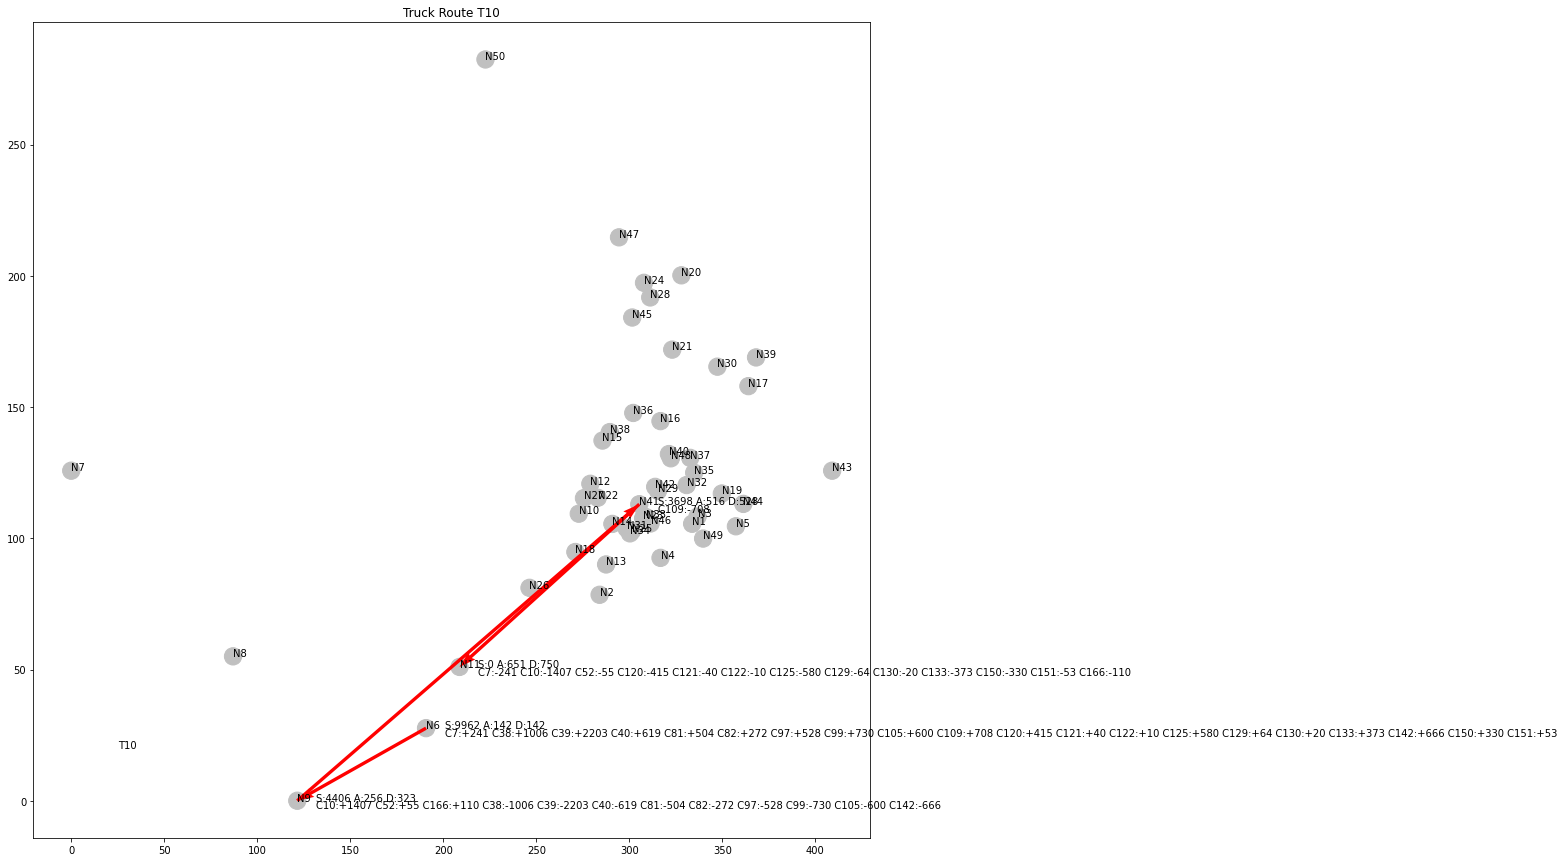

Truck Route T1


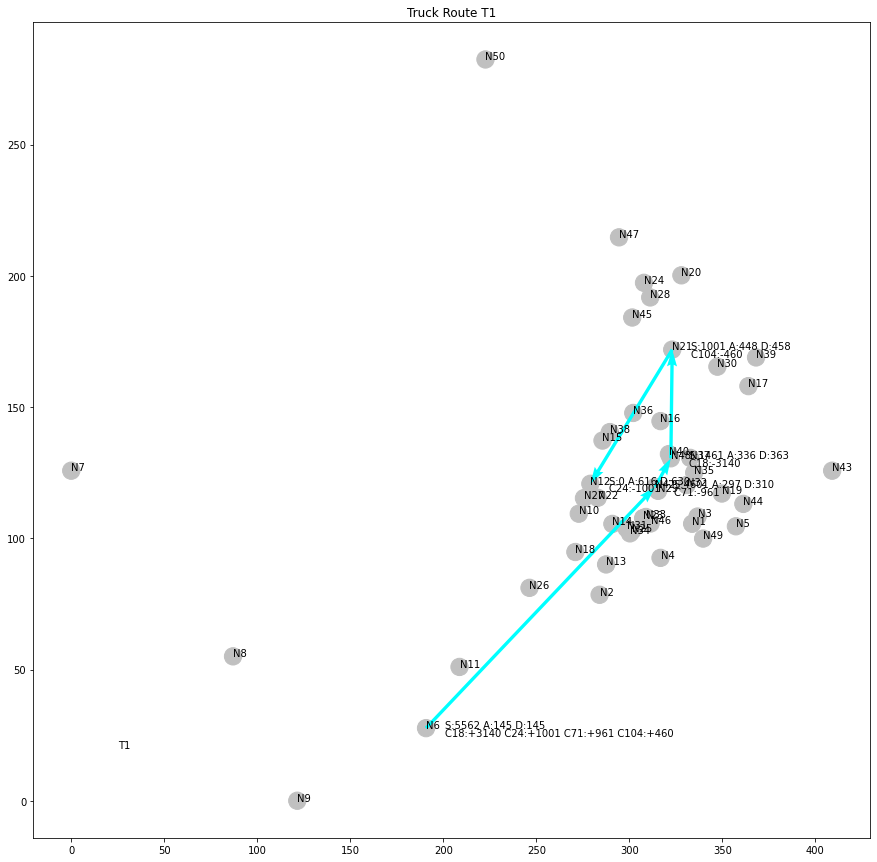

Truck Route T19


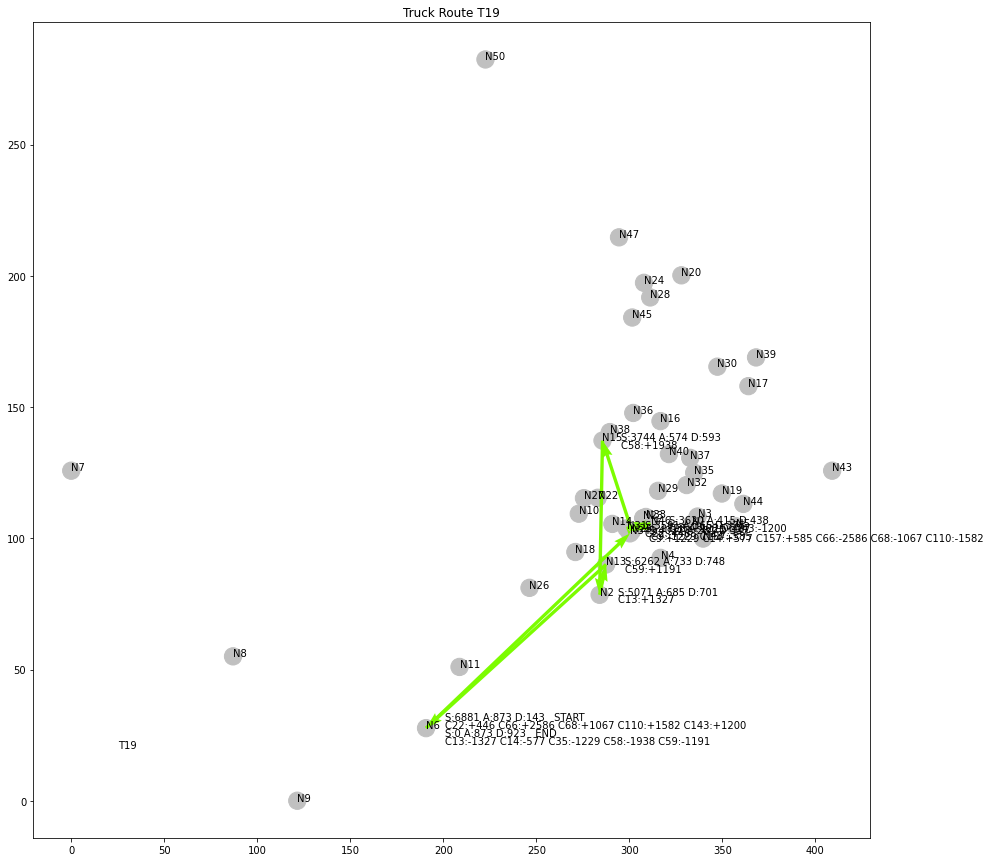

Truck Route T5


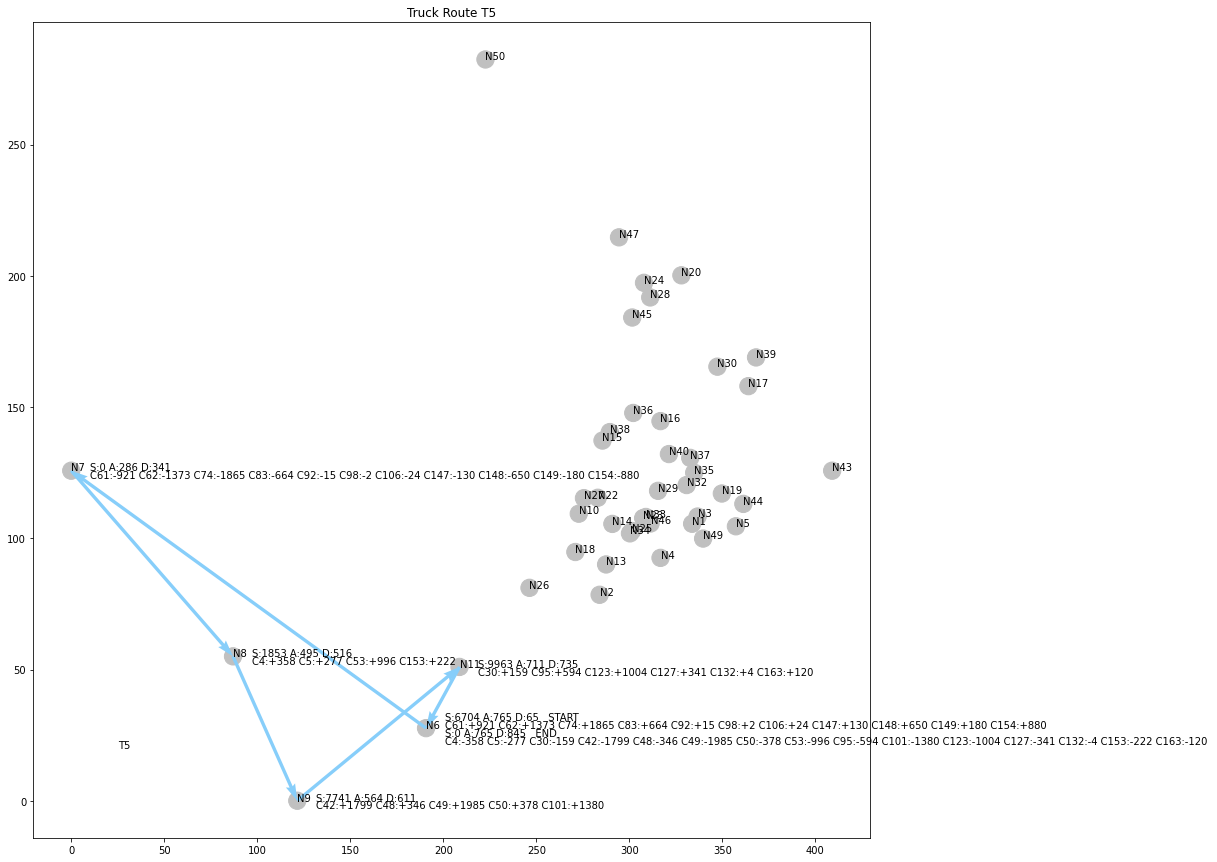

Truck Route T2


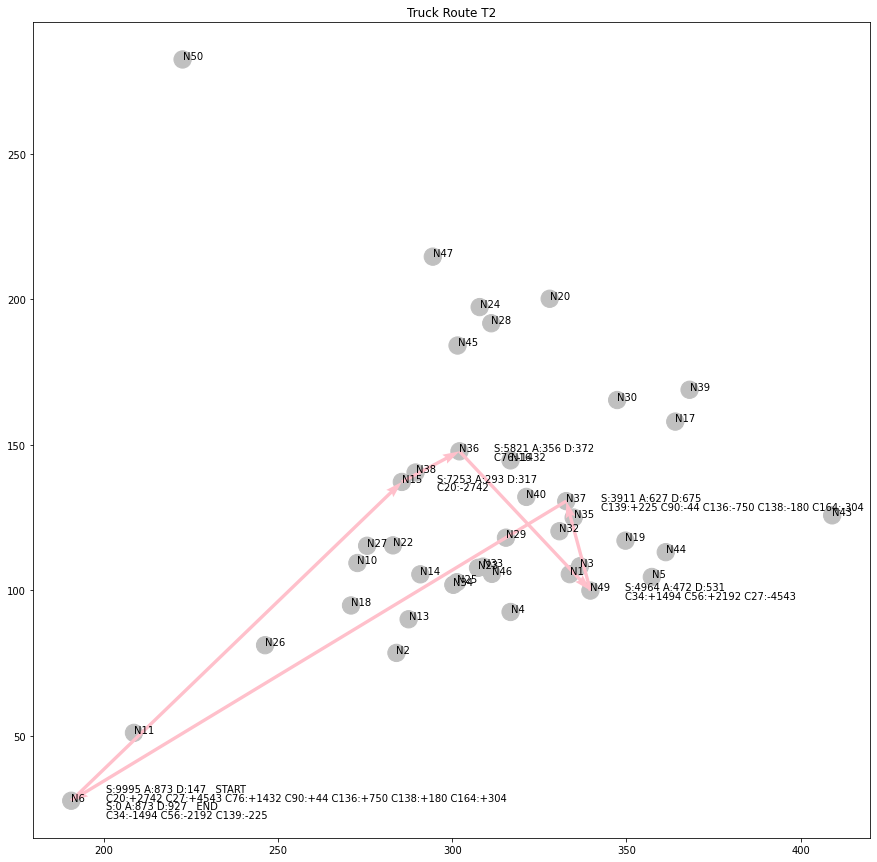

Truck Route T7


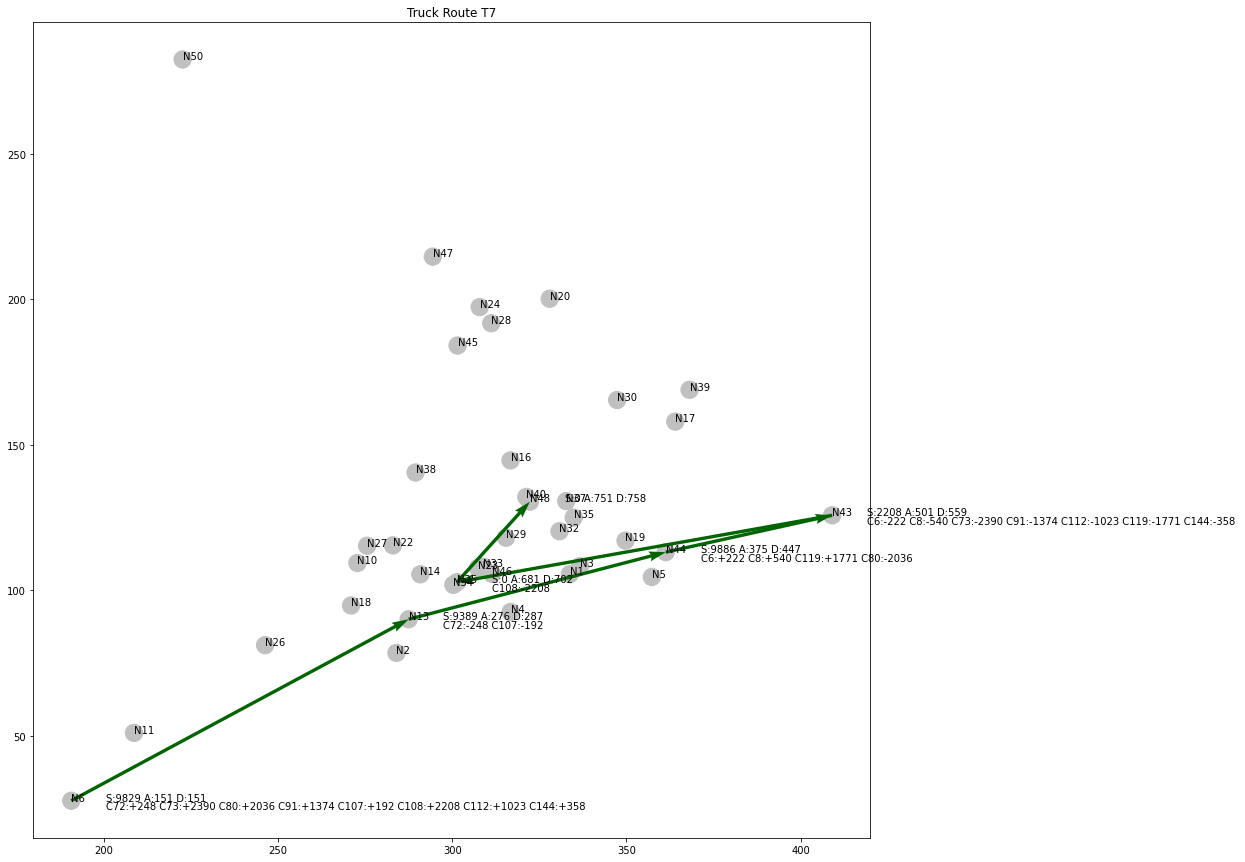

Truck Route T16


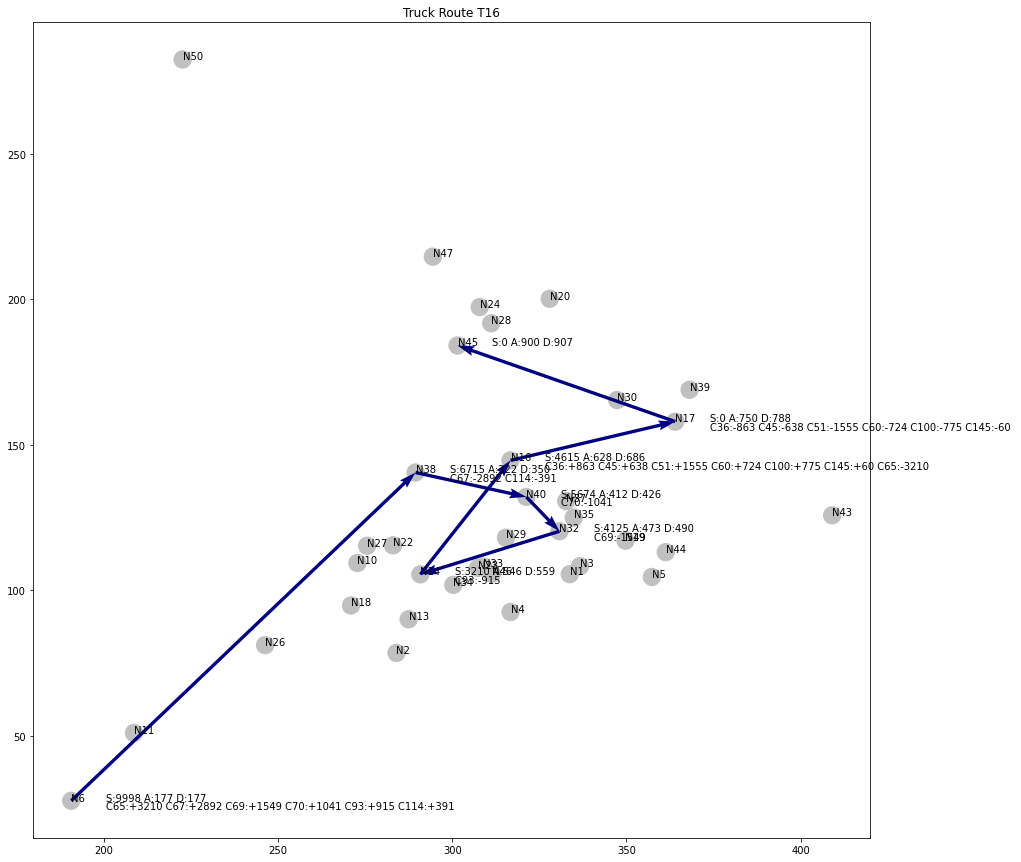

Truck Route T12


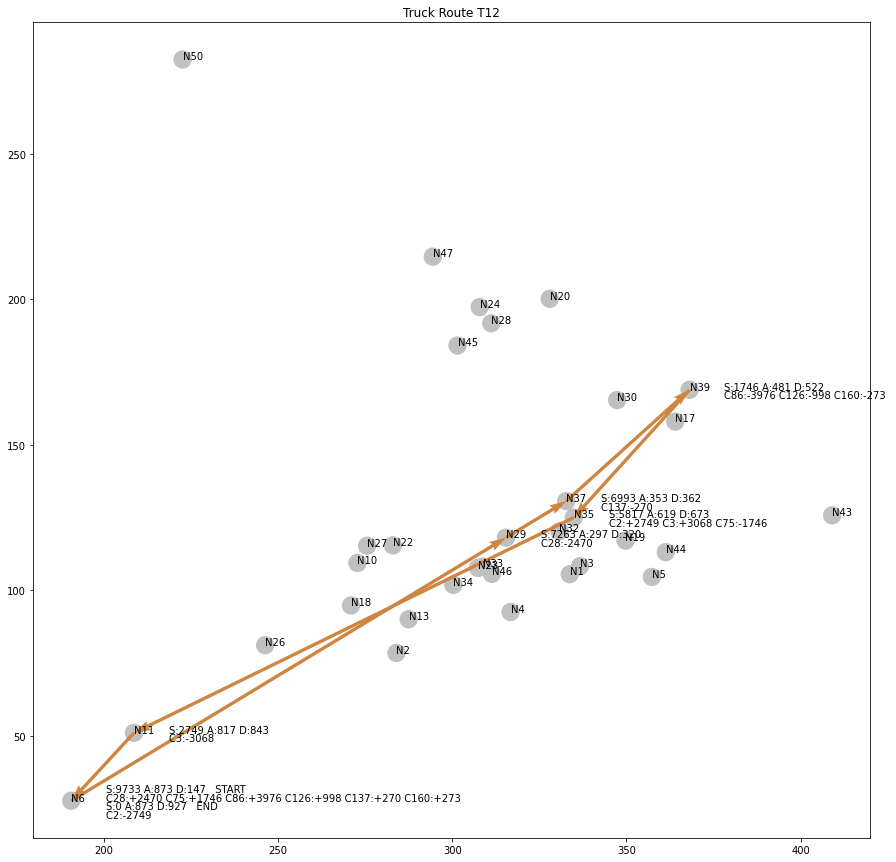

Truck Route T9


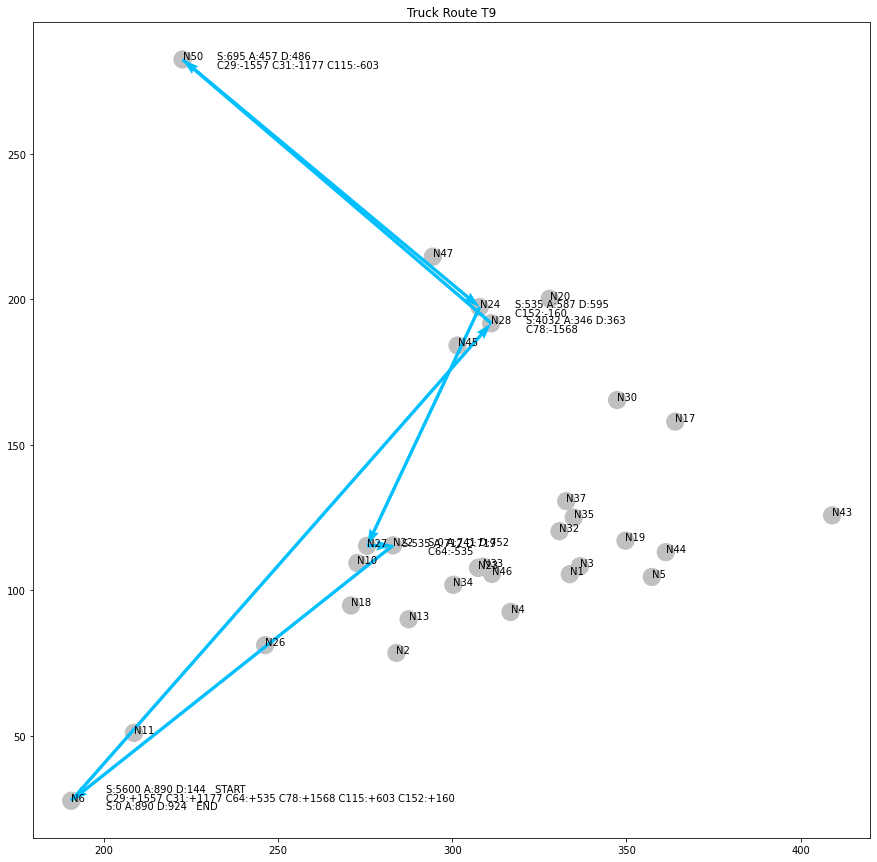

Truck Route T18


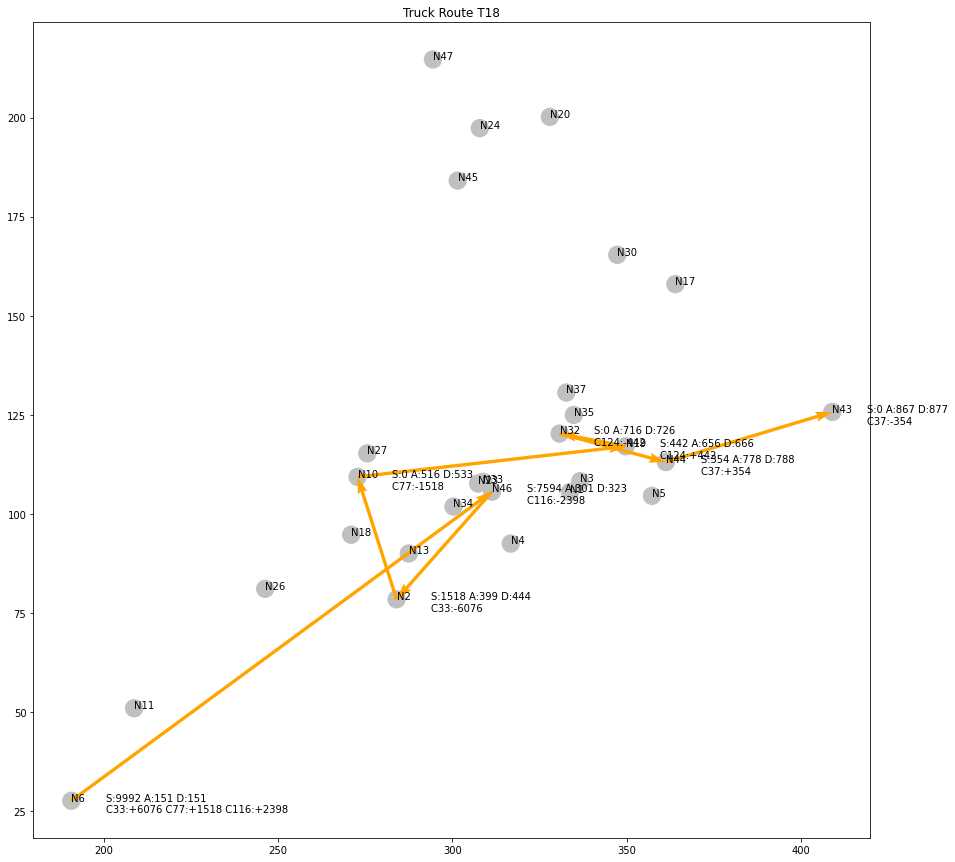

Truck Route T8


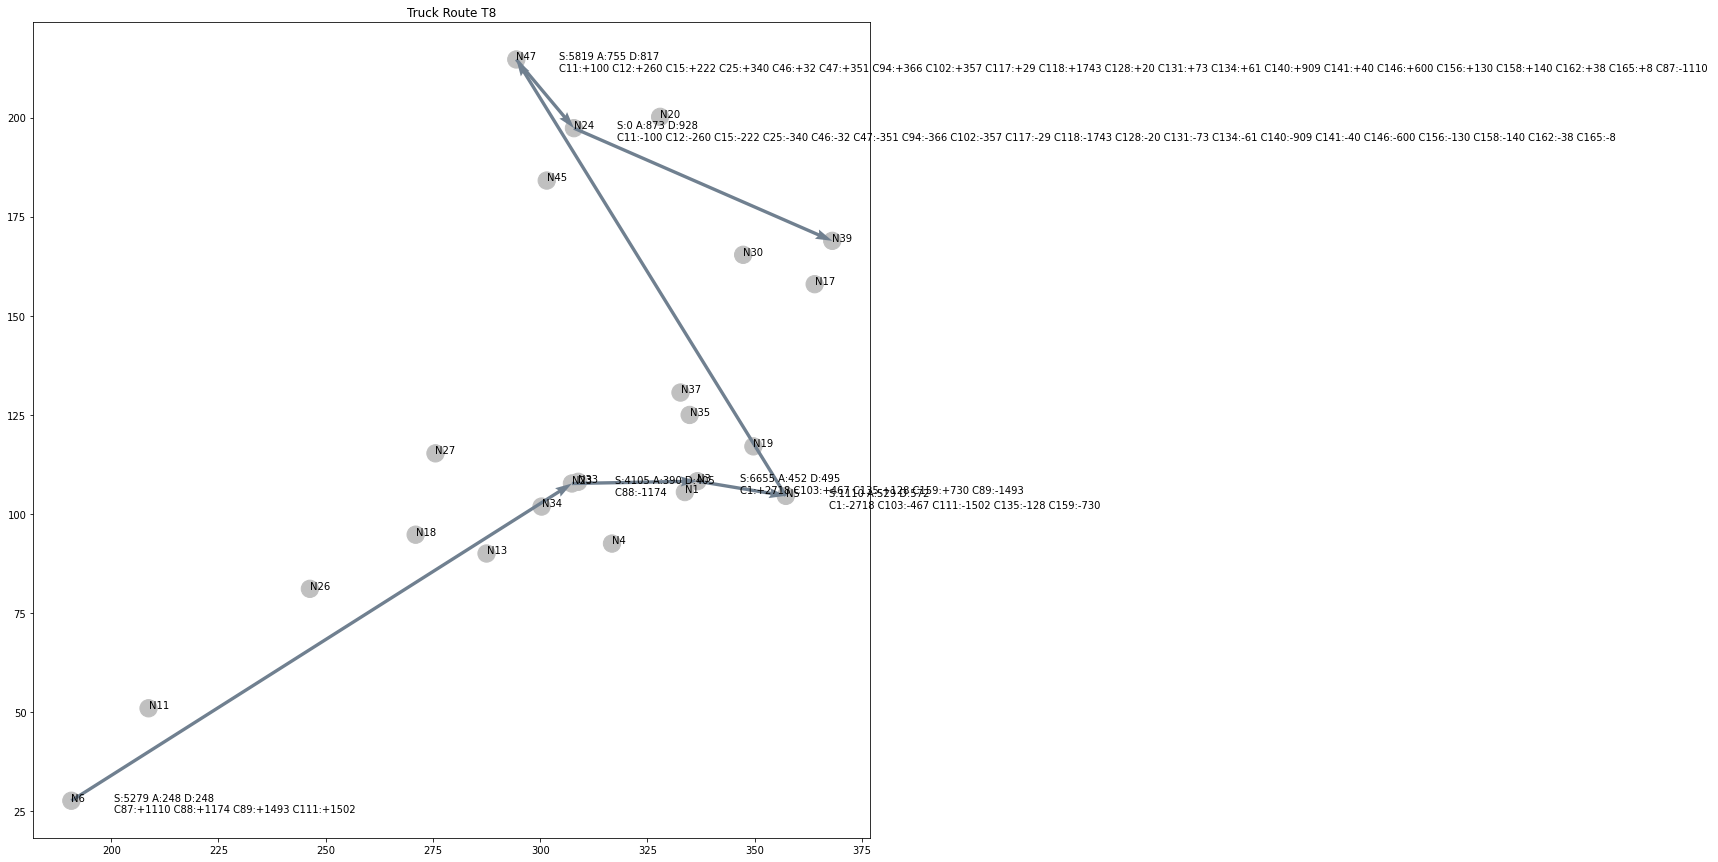

Truck Route T6


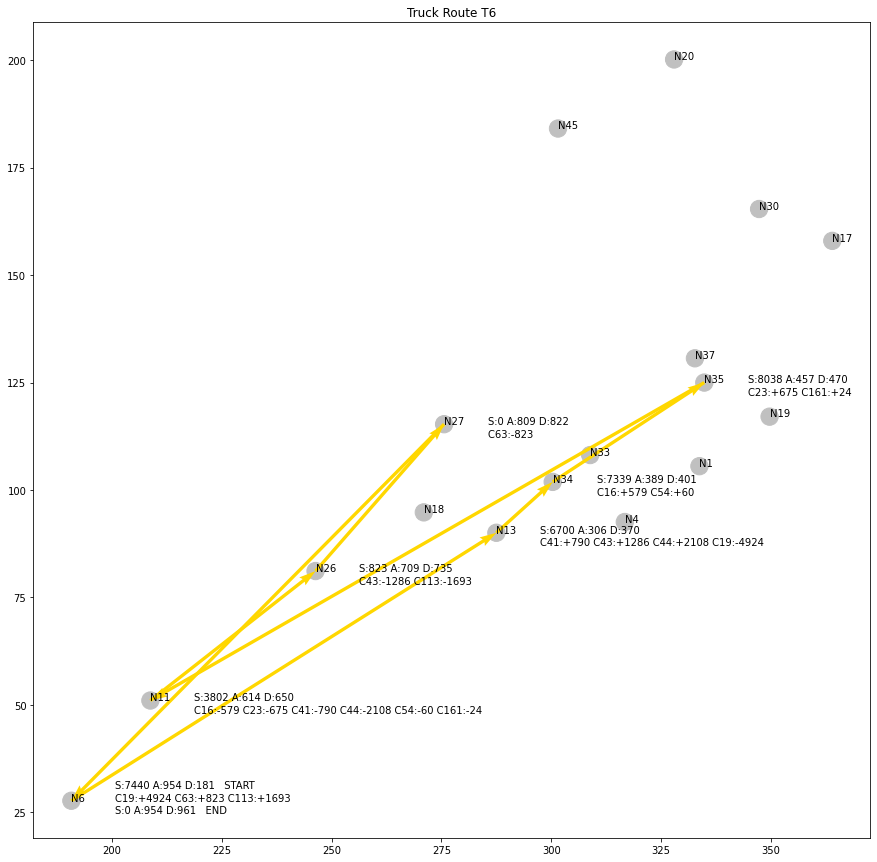

Truck Route T4


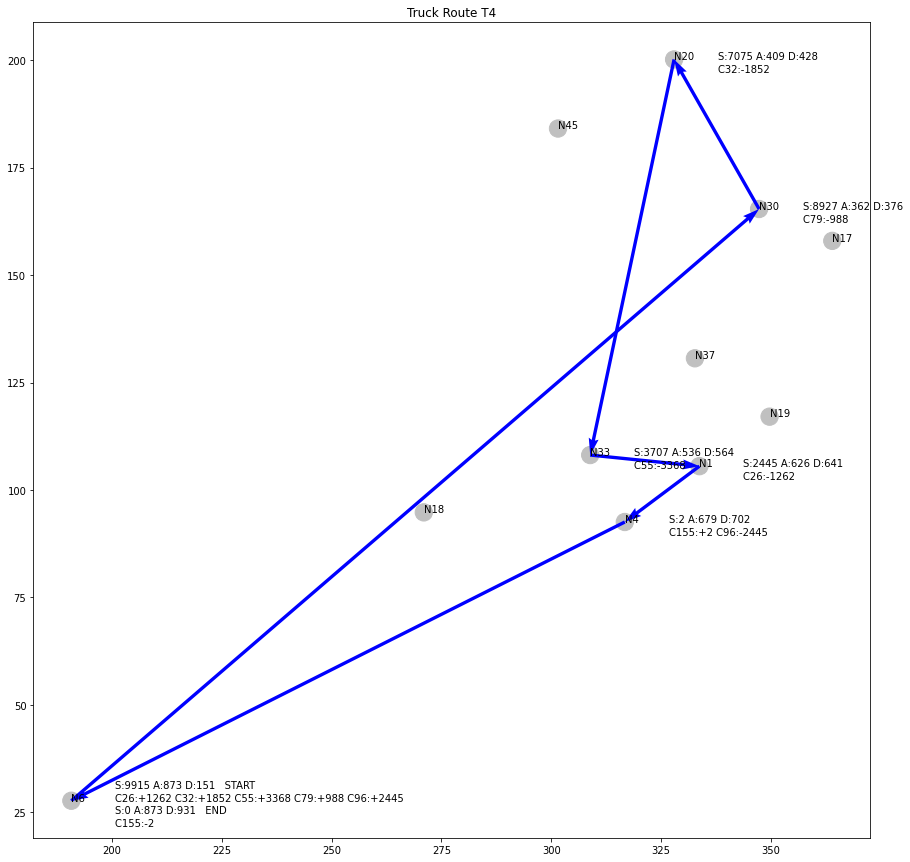

Truck Route T15


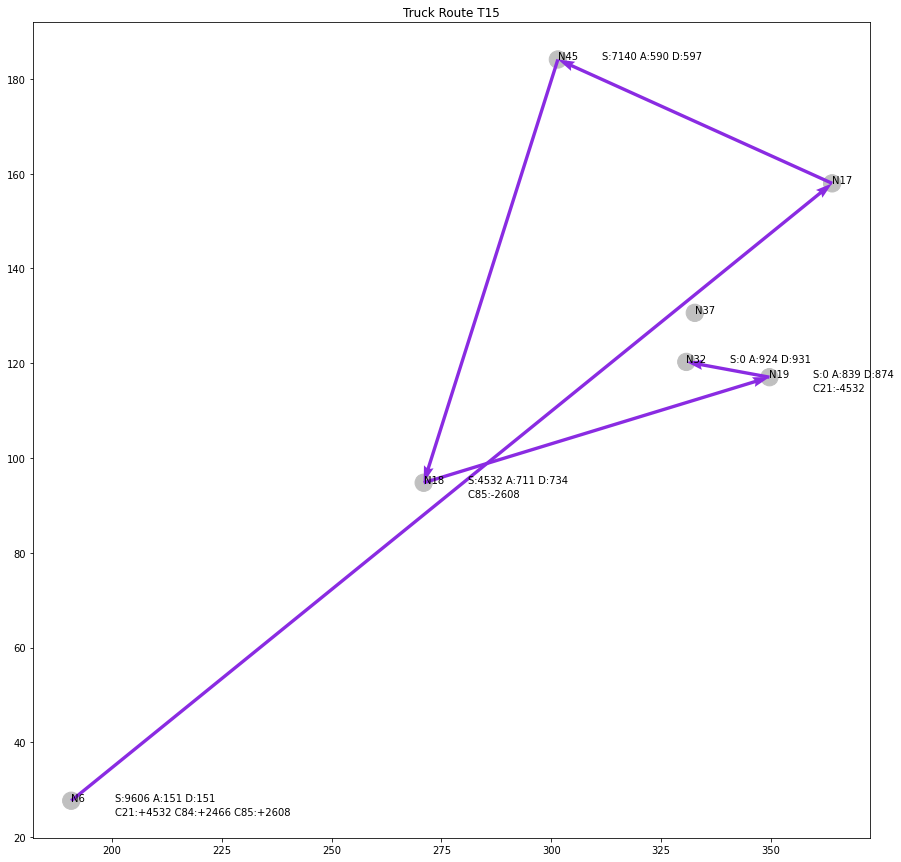

Truck Route T3


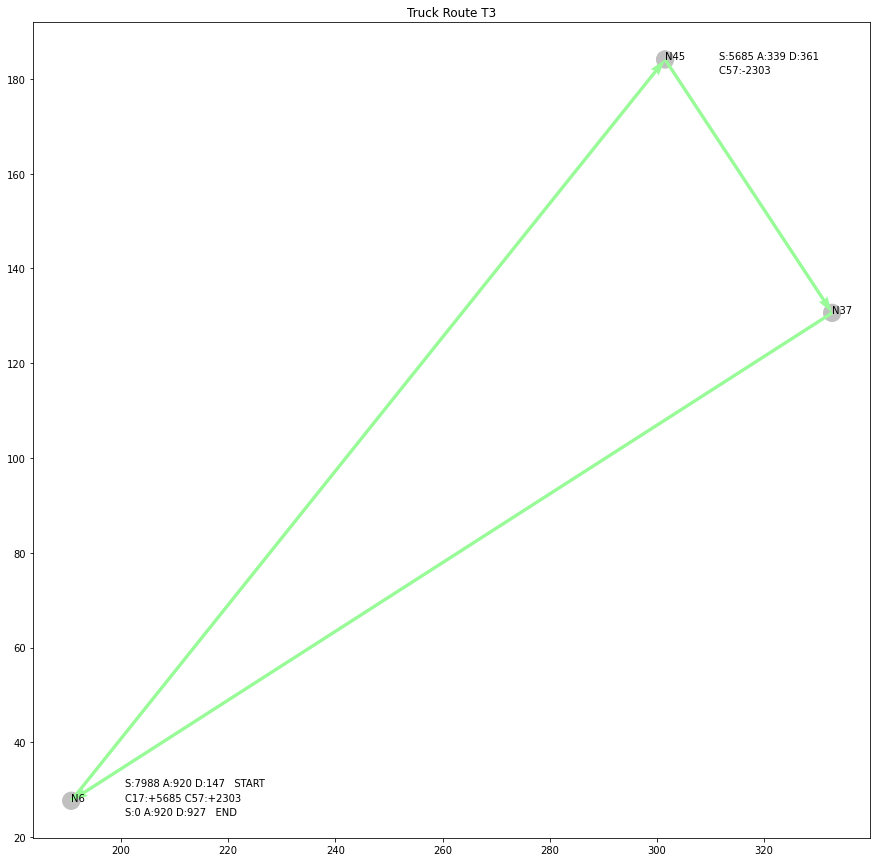

In [30]:
# plot routes
plot_gurobi_solution_FastMap_node_list_total(cargo, 
created_truck_yCycle_total, created_truck_nCycle_total, 
created_truck_all_total, node_list_truck_hubs_total,
truck_used_total, truck_route, x_sol_total, y_sol_total, 
S_sol_total, D_sol_total, A_sol_total, Sb_sol_total, Db_sol_total, Ab_sol_total, 
coordinates_FastMap)

In [31]:
# store and read PDPT solutions
store_route_solution_PDPT(cargo, created_truck_yCycle_total, 
created_truck_nCycle_total, truck, 
truck_used_total, truck_route, cargo_route, x_sol_total, y_sol_total, 
S_sol_total, D_sol_total, A_sol_total, 
Sb_sol_total, Db_sol_total, Ab_sol_total)

truck_yCycle_file, truck_used_file, truck_route_file, \
cargo_route_file, S_sol_file, A_sol_file, D_sol_file, \
Sb_sol_file, Ab_sol_file, Db_sol_file = \
read_route_solution_PDPT()

route_solution_PDPT.txt

The truck_yCycle_file 10
['T2', 'T3', 'T4', 'T5', 'T6', 'T9', 'T11', 'T12', 'T13', 'T19']

The truck_used_file 15
['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T12', 'T15', 'T16', 'T18', 'T19']

The truck_route_file 19
T1 ['N6', 'N42', 'N48', 'N21', 'N12']
T2 ['N6', 'N15', 'N36', 'N49', 'N37', 'N6']
T3 ['N6', 'N45', 'N37', 'N6']
T4 ['N6', 'N30', 'N20', 'N33', 'N1', 'N4', 'N6']
T5 ['N6', 'N7', 'N8', 'N9', 'N11', 'N6']
T6 ['N6', 'N13', 'N34', 'N35', 'N11', 'N26', 'N27', 'N6']
T7 ['N6', 'N13', 'N44', 'N43', 'N25', 'N48']
T8 ['N6', 'N23', 'N3', 'N5', 'N47', 'N24', 'N39']
T9 ['N6', 'N28', 'N50', 'N24', 'N27', 'N22', 'N6']
T10 ['N6', 'N9', 'N41', 'N11']
T11 []
T12 ['N6', 'N29', 'N37', 'N39', 'N35', 'N11', 'N6']
T13 []
T14 []
T15 ['N6', 'N17', 'N45', 'N18', 'N19', 'N32']
T16 ['N6', 'N38', 'N40', 'N32', 'N14', 'N16', 'N17', 'N45']
T17 []
T18 ['N6', 'N46', 'N2', 'N10', 'N19', 'N32', 'N44', 'N43']
T19 ['N6', 'N34', 'N31', 'N46', 'N25', 'N15', 'N2', 'N13'

In [32]:
# check solution without transfers

pickup_cargo_at, delivery_cargo_at = \
generate_dict_cargo_pd_nodes(cargo, node_list)

print('generate_dict_cargo_pd_nodes succeed!')

feasibility_flag_trucks, carried_cargo = \
manual_check_route(constant, truck, cargo, edge_shortest,
truck_yCycle_file, truck_used_file, 
truck_route_file, cargo_route_file, 
S_sol_file, A_sol_file, D_sol_file,
Sb_sol_file, Ab_sol_file, Db_sol_file,
pickup_cargo_at, delivery_cargo_at)

truck_cost, travel_cost = \
    calculate_truck_travel_cost(constant, edge_shortest,
    truck_used_file, truck_route_file)

generate_dict_cargo_pd_nodes succeed!

The feasibility_flag_trucks:
T1 1
T2 1
T3 1
T4 1
T5 1
T6 1
T7 1
T8 1
T9 1
T10 1
T12 1
T15 1
T16 1
T18 1
T19 1

The truck_cost based on the PDPT solution: 450000.0

The travel cost based on the PDPT solution: 400250.0

The total cost: 850250.0
